<div><span style="background-color: #9e4244; padding-top: 80px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: white; font-size: 22px; font-weight: bold">Session 8: Machine Learning Pipelines</span></div>

by BYJ Cirio

<div class="alert alert-danger alert-info">
     In this notebook you will learn how to automate your machine learning model pipelines. Specifically, the topics covered are as follows:<br>
    <ol>
        <li>Auto-ML</li>
        <li>Grid-search CV/Randomized Search CV</li>
        <li>Example project</li>
    </ol>
</div>

In [1]:
!pip install termcolor


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [47]:
# General Libraries
import re
import time
import warnings
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score)

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours) 
from imblearn.combine import SMOTETomek, SMOTEENN

# SHAP
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer

In [3]:
df = pd.read_csv('cc_df_group1_version2.csv')

df.drop(columns = ['trans_date'], inplace = True)

df.head()

,lat,long,city_pop,amt,is_fraud,merch_lat,merch_long,trans_day,city_Angeles City,city_Antipolo,...,part_of_day_lunch,region_CALABARZON,region_NCR,region_Region 3,quarantine_status_ECQ,quarantine_status_GCQ,quarantine_status_MECQ,quarantine_status_Normal,QL_Extreme QL,QL_Moderate-Low QL
0,14.5958,120.9772,23088000,966.24,1,14.133430,121.223118,13,0,0,...,1,0,1,0,0,1,0,0,0,1
1,14.5958,120.9772,23088000,275.37,1,15.290354,120.246084,13,0,0,...,0,0,1,0,0,1,0,0,0,1
2,14.5958,120.9772,23088000,326.96,1,15.402101,121.332516,14,0,0,...,0,0,1,0,0,1,0,0,0,1
3,14.5958,120.9772,23088000,1047.59,1,15.166276,121.955649,14,0,0,...,0,0,1,0,0,1,0,0,0,1
4,14.5958,120.9772,23088000,286.34,1,15.149144,121.696662,14,0,0,...,0,0,1,0,0,1,0,0,0,1


Would Recommend:       0
1    300
0  29677
Proportion Chance Criterion: 98.02%
1.25 * Proportion Chance Criterion: 122.52%


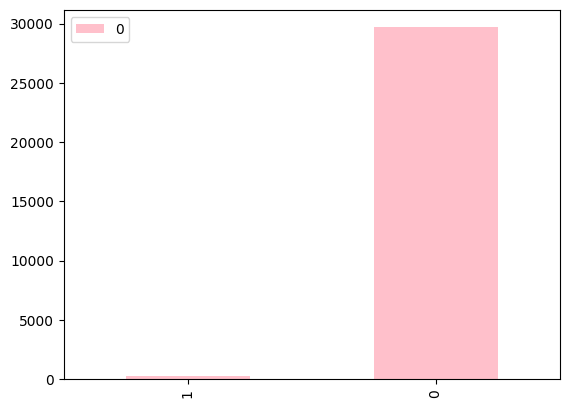

In [4]:
state_counts = Counter(df['is_fraud'])
df_state = pd.DataFrame.from_dict(state_counts, orient='index')
df_state.plot(kind='bar', color='pink')

num=(df_state[0]/df_state[0].sum())**2

print("Would Recommend:{}".format(df_state))

print("Proportion Chance Criterion: {:0.2f}%".format(100*num.sum()))
print("1.25 * Proportion Chance Criterion: {:0.2f}%".format(1.25*100*num.sum()))

In [5]:
X = df.drop(['is_fraud'], axis=1)
y = df['is_fraud']
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=11, test_size=0.25,
                                                                  stratify=y)

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Auto-ML </span></div>

In [6]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {}
    results2 = {}

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        train_scores = []
        val_scores = []

        train_recall = []
        val_recall = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))

            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]

### Baseline

In [7]:
models_dict = {'LogisticRegressor': LogisticRegression(),
              'RandomForestClassifier': RandomForestClassifier(random_state=143),
              'KNeighborsClassifier': KNeighborsClassifier(),
              'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
              'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143) }

# models_dict = {
#     'KNeighborsClassifier': KNeighborsClassifier(),
#     'LogisticRegressor': LogisticRegression(),
#     'GaussianNB': GaussianNB(),
#     'RandomForestClassifier': RandomForestClassifier(random_state=143),
#     'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
#     'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)   
# }

In [8]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
               cv=StratifiedKFold(n_splits=5))
auto = auto_run[0]
auto_run[1]

  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,99.38%,99.28%,40.22%,32.00%,0.38052
RandomForestClassifier,100.00%,99.60%,100.00%,60.89%,2.078474
KNeighborsClassifier,99.42%,99.25%,44.89%,32.00%,4.796642
DecisionTreeClassifier,100.00%,99.81%,100.00%,89.33%,0.324607
GradientBoostingClassifier,99.98%,99.79%,99.11%,91.11%,6.536518


### Applying resampling techniques

#### Oversampling

In [9]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN()),
            ('BorderlineSMOTE', BorderlineSMOTE()),
            ('SVMSMOTE', SVMSMOTE())]

outputs = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                    cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------SMOTE---------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.11107373237609863
Resampling done in 0.10837626457214355
Resampling done in 0.09692788124084473
Resampling done in 0.10245466232299805
Resampling done in 0.11248421669006348


0it [00:00, ?it/s]

Resampling done in 0.13208699226379395
Resampling done in 0.0890045166015625
Resampling done in 0.09289264678955078
Resampling done in 0.08852458000183105
Resampling done in 0.08998632431030273


0it [00:00, ?it/s]

Resampling done in 0.1102445125579834
Resampling done in 0.17107772827148438
Resampling done in 0.14618706703186035
Resampling done in 0.12860465049743652
Resampling done in 0.13011956214904785


0it [00:00, ?it/s]

Resampling done in 0.156477689743042
Resampling done in 0.19348645210266113
Resampling done in 0.15550971031188965
Resampling done in 0.11810970306396484
Resampling done in 0.0897986888885498


0it [00:00, ?it/s]

Resampling done in 0.10461902618408203
Resampling done in 0.09421634674072266
Resampling done in 0.09685397148132324
Resampling done in 0.08998966217041016
Resampling done in 0.0954899787902832


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,96.57%,95.15%,97.78%,79.56%,1.08941
RandomForestClassifier,100.00%,99.59%,100.00%,60.00%,6.202979
KNeighborsClassifier,98.55%,95.62%,100.00%,80.89%,20.545115
DecisionTreeClassifier,100.00%,99.59%,100.00%,74.67%,1.787284
GradientBoostingClassifier,99.71%,99.32%,99.93%,95.11%,28.922252


--------------------------------------------------ADASYN---------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.15152430534362793
Resampling done in 0.1602003574371338
Resampling done in 0.1632702350616455
Resampling done in 0.13975095748901367
Resampling done in 0.13270354270935059


0it [00:00, ?it/s]

Resampling done in 0.13299107551574707
Resampling done in 0.12684273719787598
Resampling done in 0.12114667892456055
Resampling done in 0.12094545364379883
Resampling done in 0.12305545806884766


0it [00:00, ?it/s]

Resampling done in 0.12577342987060547
Resampling done in 0.20380306243896484
Resampling done in 0.1425001621246338
Resampling done in 0.1752300262451172
Resampling done in 0.14006757736206055


0it [00:00, ?it/s]

Resampling done in 0.14256954193115234
Resampling done in 0.13099932670593262
Resampling done in 0.13401579856872559
Resampling done in 0.12460017204284668
Resampling done in 0.12029123306274414


0it [00:00, ?it/s]

Resampling done in 0.12432599067687988
Resampling done in 0.12546539306640625
Resampling done in 0.14699864387512207
Resampling done in 0.15459966659545898
Resampling done in 0.12579584121704102


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,96.50%,94.64%,98.21%,81.33%,0.795228
RandomForestClassifier,100.00%,99.58%,100.00%,58.22%,6.501019
KNeighborsClassifier,98.54%,95.62%,100.00%,80.89%,15.876207
DecisionTreeClassifier,100.00%,99.52%,100.00%,73.33%,1.696222
GradientBoostingClassifier,99.76%,99.46%,99.91%,95.11%,28.713314


----------------------------------------------BorderlineSMOTE----------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.14964556694030762
Resampling done in 0.17327451705932617
Resampling done in 0.20466089248657227
Resampling done in 0.20610904693603516
Resampling done in 0.18112587928771973


0it [00:00, ?it/s]

Resampling done in 0.19328618049621582
Resampling done in 0.12399721145629883
Resampling done in 0.12176799774169922
Resampling done in 0.1230003833770752
Resampling done in 0.11864209175109863


0it [00:00, ?it/s]

Resampling done in 0.12249875068664551
Resampling done in 0.15857768058776855
Resampling done in 0.15378332138061523
Resampling done in 0.1584622859954834
Resampling done in 0.15639638900756836


0it [00:00, ?it/s]

Resampling done in 0.14903688430786133
Resampling done in 0.1259765625
Resampling done in 0.12854456901550293
Resampling done in 0.12534284591674805
Resampling done in 0.13114118576049805


0it [00:00, ?it/s]

Resampling done in 0.1307361125946045
Resampling done in 0.14710116386413574
Resampling done in 0.12950730323791504
Resampling done in 0.12272810935974121
Resampling done in 0.1370234489440918


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,97.23%,95.90%,98.28%,76.44%,1.249955
RandomForestClassifier,100.00%,99.56%,100.00%,58.67%,6.528521
KNeighborsClassifier,98.65%,95.86%,99.99%,80.44%,16.183063
DecisionTreeClassifier,100.00%,99.59%,100.00%,76.89%,1.824156
GradientBoostingClassifier,99.75%,99.41%,99.95%,95.56%,29.919935


-------------------------------------------------SVMSMOTE--------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 2.3594448566436768
Resampling done in 2.271787405014038
Resampling done in 2.542789936065674
Resampling done in 2.30236554145813
Resampling done in 2.376647710800171


0it [00:00, ?it/s]

Resampling done in 2.464057207107544
Resampling done in 2.511107921600342
Resampling done in 2.167914628982544
Resampling done in 2.218846082687378
Resampling done in 2.2572829723358154


0it [00:00, ?it/s]

Resampling done in 2.3455827236175537
Resampling done in 2.381837844848633
Resampling done in 2.2282543182373047
Resampling done in 2.2497663497924805
Resampling done in 2.634065628051758


0it [00:00, ?it/s]

Resampling done in 2.621406316757202
Resampling done in 2.32387113571167
Resampling done in 2.176901340484619
Resampling done in 2.4654042720794678
Resampling done in 2.2102606296539307


0it [00:00, ?it/s]

Resampling done in 2.2761709690093994
Resampling done in 2.5206174850463867
Resampling done in 2.266338586807251
Resampling done in 2.1982321739196777
Resampling done in 2.3886027336120605


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,97.82%,97.03%,98.32%,74.22%,0.969244
RandomForestClassifier,100.00%,99.60%,100.00%,61.33%,5.994793
KNeighborsClassifier,98.69%,96.03%,99.99%,80.00%,16.366833
DecisionTreeClassifier,100.00%,99.50%,100.00%,71.11%,1.897197
GradientBoostingClassifier,99.71%,99.45%,99.90%,95.11%,28.111983


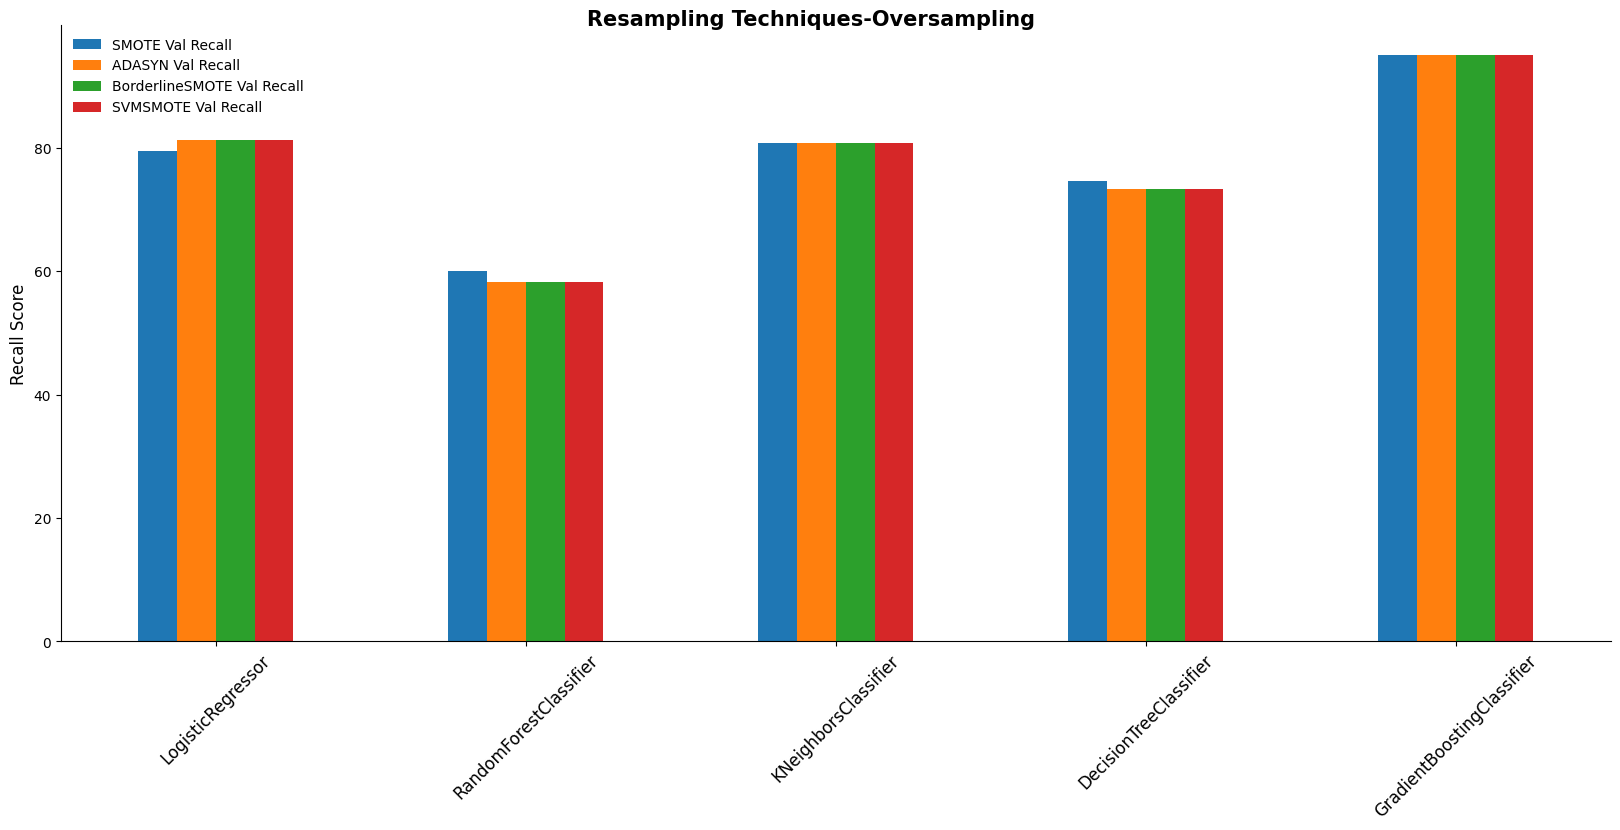

In [10]:
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over['ADASYN Val Recall'] = outputs[1]['Val Recall']
ps_over['BorderlineSMOTE Val Recall'] = outputs[1]['Val Recall']
ps_over['SVMSMOTE Val Recall'] = outputs[1]['Val Recall']
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

#### Undersampling

In [11]:
res_list = [('TomekLinks', TomekLinks()),
            ('NearMiss', NearMiss()),
            ('ALLKNN', AllKNN()),
            ('EditedNearestNeighbours', EditedNearestNeighbours()),
            ('RepeatedEditedNearestNeighbours', RepeatedEditedNearestNeighbours())]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

------------------------------------------------TomekLinks-------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 1.5745964050292969
Resampling done in 1.711467981338501
Resampling done in 1.6576249599456787
Resampling done in 1.693692922592163
Resampling done in 1.873448371887207


0it [00:00, ?it/s]

Resampling done in 1.8776686191558838
Resampling done in 1.5819647312164307
Resampling done in 1.5669364929199219
Resampling done in 1.8179881572723389
Resampling done in 1.6705553531646729


0it [00:00, ?it/s]

Resampling done in 1.6479980945587158
Resampling done in 1.6874339580535889
Resampling done in 1.6264288425445557
Resampling done in 1.8132061958312988
Resampling done in 1.6571898460388184


0it [00:00, ?it/s]

Resampling done in 1.6688001155853271
Resampling done in 1.7995519638061523
Resampling done in 1.7959470748901367
Resampling done in 1.6070458889007568
Resampling done in 1.5555226802825928


0it [00:00, ?it/s]

Resampling done in 1.7056379318237305
Resampling done in 1.63653564453125
Resampling done in 1.5856547355651855
Resampling done in 1.5410454273223877
Resampling done in 1.674126148223877


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,99.38%,99.28%,40.33%,32.00%,0.459416
RandomForestClassifier,100.00%,99.59%,100.00%,60.00%,3.23338
KNeighborsClassifier,99.45%,99.25%,47.00%,32.89%,5.040291
DecisionTreeClassifier,100.00%,99.81%,100.00%,89.78%,0.673218
GradientBoostingClassifier,99.98%,99.78%,99.33%,92.00%,12.887822


-------------------------------------------------NearMiss--------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.07614636421203613
Resampling done in 0.07801127433776855
Resampling done in 0.07463359832763672
Resampling done in 0.07460927963256836
Resampling done in 0.07346248626708984


0it [00:00, ?it/s]

Resampling done in 0.08079028129577637
Resampling done in 0.0794687271118164
Resampling done in 0.07607412338256836
Resampling done in 0.06950092315673828
Resampling done in 0.07043933868408203


0it [00:00, ?it/s]

Resampling done in 0.07857179641723633
Resampling done in 0.08219361305236816
Resampling done in 0.07352066040039062
Resampling done in 0.07393312454223633
Resampling done in 0.07328057289123535


0it [00:00, ?it/s]

Resampling done in 0.07999753952026367
Resampling done in 0.08246302604675293
Resampling done in 0.08150434494018555
Resampling done in 0.08366727828979492
Resampling done in 0.07949495315551758


0it [00:00, ?it/s]

Resampling done in 0.08550000190734863
Resampling done in 0.07699990272521973
Resampling done in 0.07232379913330078
Resampling done in 0.07154965400695801
Resampling done in 0.0719289779663086


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,87.06%,52.04%,79.22%,77.33%,0.023122
RandomForestClassifier,100.00%,71.12%,100.00%,92.44%,0.260039
KNeighborsClassifier,78.28%,58.75%,74.00%,78.67%,0.264187
DecisionTreeClassifier,100.00%,93.34%,100.00%,93.78%,0.015502
GradientBoostingClassifier,100.00%,93.97%,100.00%,96.00%,0.198568


--------------------------------------------------ALLKNN---------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 4.771486043930054
Resampling done in 5.210852146148682
Resampling done in 4.766960144042969
Resampling done in 4.828280448913574
Resampling done in 4.965540647506714


0it [00:00, ?it/s]

Resampling done in 4.715037822723389
Resampling done in 5.0567467212677
Resampling done in 4.844640016555786
Resampling done in 5.177915811538696
Resampling done in 5.166440725326538


0it [00:00, ?it/s]

Resampling done in 5.3951520919799805
Resampling done in 5.044996976852417
Resampling done in 4.995858192443848
Resampling done in 5.532513380050659
Resampling done in 6.620265245437622


0it [00:00, ?it/s]

Resampling done in 4.998148202896118
Resampling done in 5.233953475952148
Resampling done in 5.058774948120117
Resampling done in 4.633737564086914
Resampling done in 4.81980562210083


0it [00:00, ?it/s]

Resampling done in 4.802247762680054
Resampling done in 4.658768653869629
Resampling done in 4.648943185806274
Resampling done in 4.706396102905273
Resampling done in 4.725810289382935


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,99.38%,99.28%,40.67%,32.44%,0.34455
RandomForestClassifier,100.00%,99.60%,100.00%,60.44%,3.120851
KNeighborsClassifier,99.54%,99.24%,54.22%,35.11%,5.487318
DecisionTreeClassifier,100.00%,99.74%,100.00%,87.56%,0.660859
GradientBoostingClassifier,99.99%,99.80%,99.44%,92.00%,12.365644


------------------------------------------EditedNearestNeighbours------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 1.5927708148956299
Resampling done in 1.5840396881103516
Resampling done in 1.583289384841919
Resampling done in 1.7125084400177002
Resampling done in 1.647341012954712


0it [00:00, ?it/s]

Resampling done in 1.6679866313934326
Resampling done in 1.6225063800811768
Resampling done in 1.5090761184692383
Resampling done in 1.5083165168762207
Resampling done in 1.4924662113189697


0it [00:00, ?it/s]

Resampling done in 1.5200493335723877
Resampling done in 1.7543246746063232
Resampling done in 1.5721435546875
Resampling done in 1.5797703266143799
Resampling done in 1.5918326377868652


0it [00:00, ?it/s]

Resampling done in 1.5869896411895752
Resampling done in 1.5631587505340576
Resampling done in 1.844801425933838
Resampling done in 1.5869851112365723
Resampling done in 1.7512285709381104


0it [00:00, ?it/s]

Resampling done in 1.6705255508422852
Resampling done in 1.506667137145996
Resampling done in 1.535682201385498
Resampling done in 1.7001211643218994
Resampling done in 1.745823860168457


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,99.38%,99.28%,40.78%,32.00%,0.389361
RandomForestClassifier,100.00%,99.56%,100.00%,56.89%,3.01869
KNeighborsClassifier,99.53%,99.25%,54.11%,35.11%,4.965582
DecisionTreeClassifier,100.00%,99.73%,100.00%,87.11%,0.666114
GradientBoostingClassifier,99.99%,99.79%,99.44%,92.00%,13.298064


--------------------------------------RepeatedEditedNearestNeighbours--------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 6.581077575683594
Resampling done in 8.696937561035156
Resampling done in 8.51711368560791
Resampling done in 6.272766351699829
Resampling done in 8.056565284729004


0it [00:00, ?it/s]

Resampling done in 6.361006498336792
Resampling done in 8.57555890083313
Resampling done in 8.784409284591675
Resampling done in 7.107774257659912
Resampling done in 8.376630067825317


0it [00:00, ?it/s]

Resampling done in 7.226651906967163
Resampling done in 8.54253363609314
Resampling done in 8.148616552352905
Resampling done in 7.2605180740356445
Resampling done in 8.97505235671997


0it [00:00, ?it/s]

Resampling done in 6.501384496688843
Resampling done in 9.783121347427368
Resampling done in 8.239659309387207
Resampling done in 7.987949848175049
Resampling done in 8.962510347366333


0it [00:00, ?it/s]

Resampling done in 6.9147233963012695
Resampling done in 8.356932878494263
Resampling done in 8.5685875415802
Resampling done in 6.372896909713745
Resampling done in 8.274343490600586


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,99.38%,99.28%,40.89%,32.44%,0.353852
RandomForestClassifier,100.00%,99.63%,100.00%,62.67%,3.610306
KNeighborsClassifier,99.55%,99.22%,55.33%,35.11%,5.221387
DecisionTreeClassifier,100.00%,99.74%,100.00%,87.56%,0.737388
GradientBoostingClassifier,99.99%,99.81%,99.56%,92.44%,13.263901


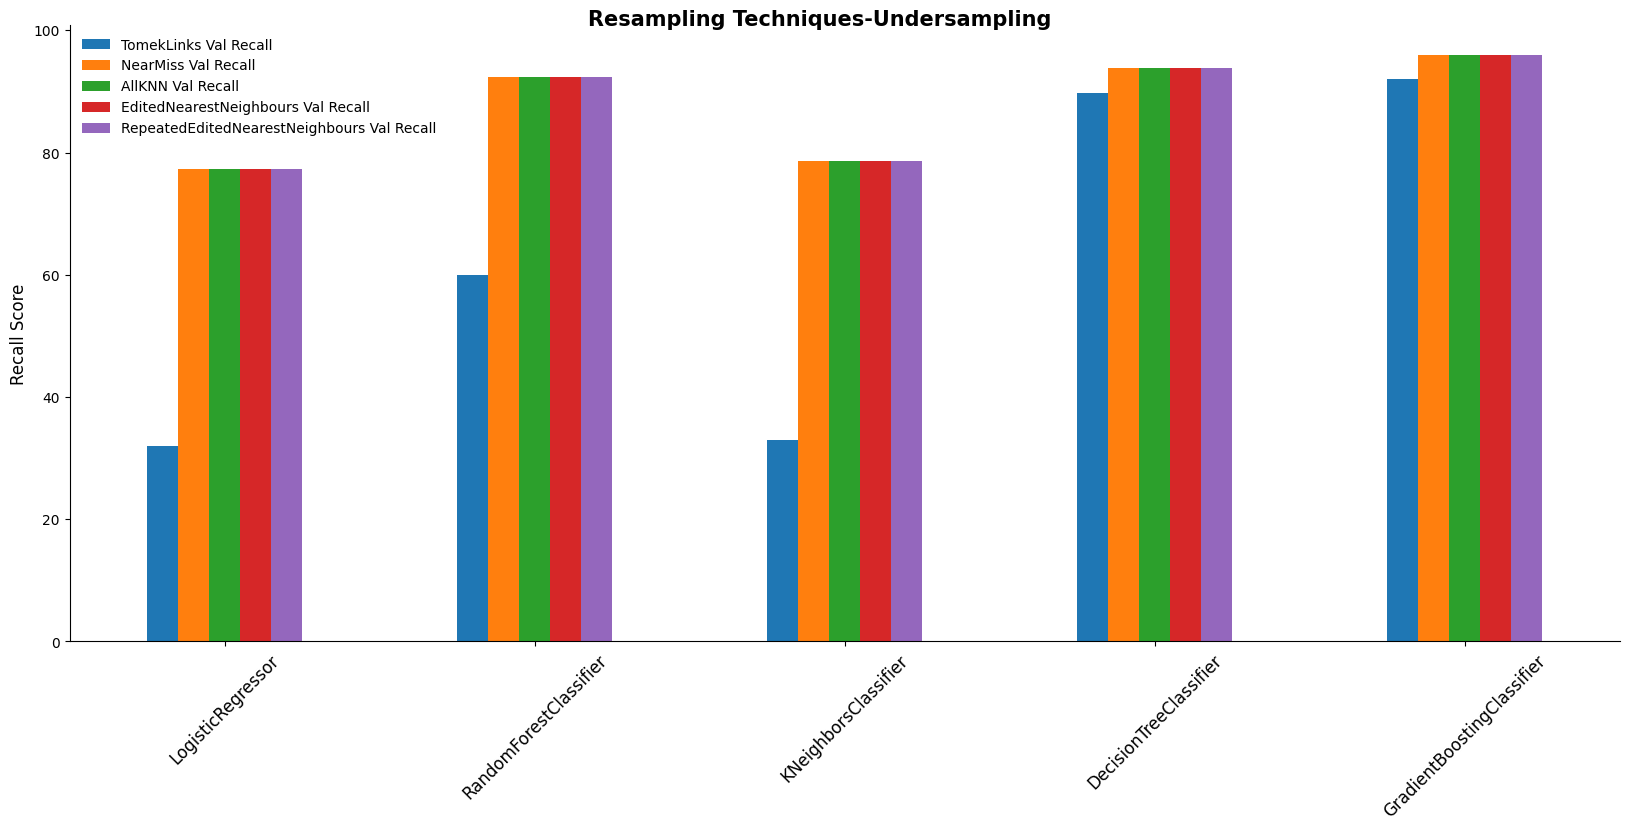

In [12]:
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_under['TomekLinks Val Recall'] = outputs_u[0]['Val Recall']
ps_under['NearMiss Val Recall'] = outputs_u[1]['Val Recall']
ps_under['AllKNN Val Recall'] = outputs_u[1]['Val Recall']
ps_under['EditedNearestNeighbours Val Recall'] = outputs_u[1]['Val Recall']
ps_under['RepeatedEditedNearestNeighbours Val Recall'] = outputs_u[1]['Val Recall']

fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

#### Combined Resampling

In [13]:
res_list = [('SMOTETomek', SMOTETomek()),
            ('SMOTEENN', SMOTEENN())]

outputs_c = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=MinMaxScaler(),
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_c.append(var[0])
    display(var[1])

------------------------------------------------SMOTETomek-------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 7.785796642303467
Resampling done in 7.099437713623047
Resampling done in 6.732495546340942
Resampling done in 6.990526914596558
Resampling done in 6.7132651805877686


0it [00:00, ?it/s]

Resampling done in 6.7594990730285645
Resampling done in 6.989581346511841
Resampling done in 6.5796287059783936
Resampling done in 6.724448919296265
Resampling done in 6.536479234695435


0it [00:00, ?it/s]

Resampling done in 6.431770324707031
Resampling done in 6.958238840103149
Resampling done in 6.619035720825195
Resampling done in 7.032256126403809
Resampling done in 7.056950569152832


0it [00:00, ?it/s]

Resampling done in 6.976301193237305
Resampling done in 7.062942266464233
Resampling done in 7.591821908950806
Resampling done in 7.028648614883423
Resampling done in 6.50143575668335


0it [00:00, ?it/s]

Resampling done in 7.80704402923584
Resampling done in 6.576313257217407
Resampling done in 8.814298868179321
Resampling done in 6.4436376094818115
Resampling done in 6.206566572189331


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,96.61%,95.13%,97.81%,80.00%,1.142824
RandomForestClassifier,100.00%,99.58%,100.00%,59.56%,8.103696
KNeighborsClassifier,98.55%,95.62%,100.00%,80.89%,18.046686
DecisionTreeClassifier,100.00%,99.59%,100.00%,75.56%,1.861796
GradientBoostingClassifier,99.71%,99.34%,99.93%,95.56%,30.153615


-------------------------------------------------SMOTEENN--------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 7.29784893989563
Resampling done in 7.414766550064087
Resampling done in 7.091083288192749
Resampling done in 7.413560628890991
Resampling done in 6.695858478546143


0it [00:00, ?it/s]

Resampling done in 6.875611782073975
Resampling done in 7.2277257442474365
Resampling done in 6.369156360626221
Resampling done in 6.886124134063721
Resampling done in 7.036350250244141


0it [00:00, ?it/s]

Resampling done in 6.5419275760650635
Resampling done in 6.801532745361328
Resampling done in 6.434561729431152
Resampling done in 6.5631372928619385
Resampling done in 6.488861560821533


0it [00:00, ?it/s]

Resampling done in 6.591917514801025
Resampling done in 6.595079660415649
Resampling done in 6.770963430404663
Resampling done in 6.570685863494873
Resampling done in 6.808863162994385


0it [00:00, ?it/s]

Resampling done in 6.434988737106323
Resampling done in 6.747970104217529
Resampling done in 7.013998508453369
Resampling done in 6.4065163135528564
Resampling done in 7.13775110244751


,Train Accuracy,Val Accuracy,Train Recall,Val Recall,Run Time
LogisticRegressor,96.78%,94.56%,98.05%,80.00%,1.127047
RandomForestClassifier,100.00%,99.61%,100.00%,62.67%,6.2597
KNeighborsClassifier,99.87%,94.20%,100.00%,84.00%,15.877265
DecisionTreeClassifier,100.00%,99.52%,100.00%,72.89%,1.908226
GradientBoostingClassifier,99.71%,99.26%,99.92%,95.56%,29.33498


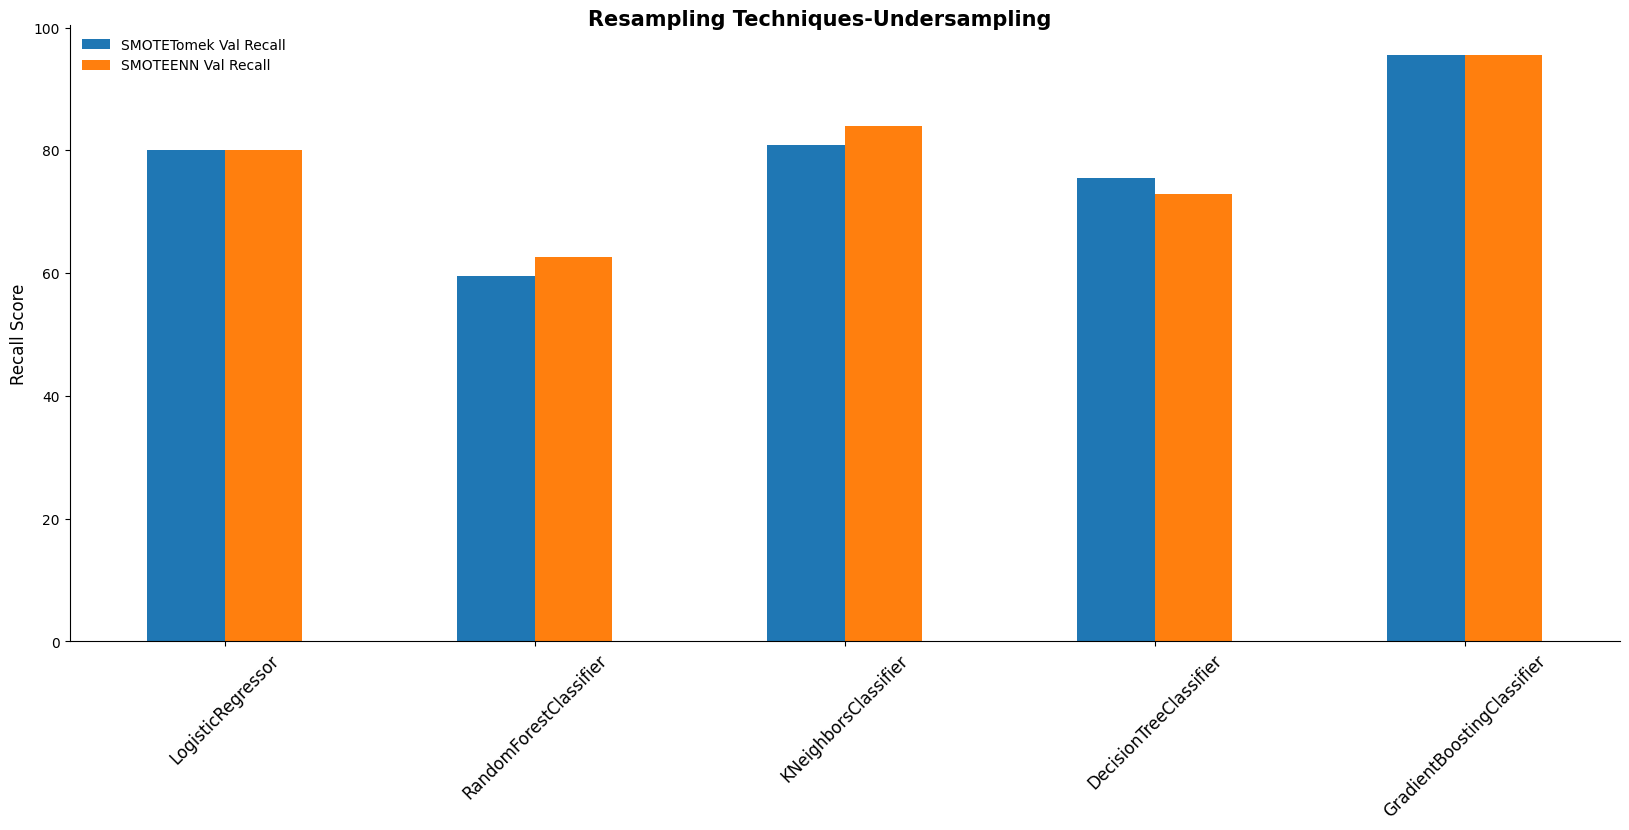

In [16]:
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[1]['Val Recall']
ps_under['SMOTETomek Val Recall'] = outputs_c[0]['Val Recall']
ps_under['SMOTEENN Val Recall'] = outputs_c[1]['Val Recall']

fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Recall Score', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Grid-Search and Randomized Search Cross Validation </span></div>

[Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [Randomized Search Cross Validation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) are commonly used to hypertune models across multiple parameters

In [21]:
def train_rf(X, y, metric, res_t=None, hypertune=False, resample=False):
    """Hypertune Gradient Boosting and apply NearMiss()"""
    params = {'n_estimators': [1, 2, 4, 8, 16, 32, 64, 100, 200],
              'learning_rate': [0.1, 0.15, 0.2, 0.25, 0.3],
              'max_depth': list(range(3, 10))
              }
    new_params = {'gradientboostingclassifier__' +
                  key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      res_t,
                                      GradientBoostingClassifier(random_state=143))
    else:
        imba_pipeline = make_pipeline(MinMaxScaler(),
                                      GradientBoostingClassifier(random_state=143))

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                           cv=skf, scoring=metric, return_train_score=True,
                          verbose=10)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['Gradient Boosting Classifier', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric, cv=skf, n_jobs=-1,
                                   return_train_score=True)

        return ['Gradient Boosting Classifier', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

In [22]:
start_time = time.time()
rf_tmk_rec = train_rf(X_trainval, y_trainval, 'recall', NearMiss(),
                       hypertune=True, resample=True)
start_time = time.time()
rf_tmk_acc = train_rf(X_trainval, y_trainval, 'accuracy', NearMiss(),
                      hypertune=True, resample=True)

Fitting 5 folds for each of 315 candidates, totalling 1575 fits
[CV 1/5; 1/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=1
[CV 1/5; 1/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=1;, score=(train=0.961, test=0.978) total time=   0.1s
[CV 2/5; 1/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=1
[CV 2/5; 1/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=1;, score=(train=0.972, test=0.867) total time=   0.1s
[CV 3/5; 1/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=1
[CV 3/5; 1/315] END gradientboostingclassifier__learning_rate=0.1, gr

[CV 4/5; 5/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=16;, score=(train=0.972, test=0.911) total time=   0.1s
[CV 5/5; 5/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=16
[CV 5/5; 5/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=16;, score=(train=0.972, test=0.889) total time=   0.1s
[CV 1/5; 6/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=32
[CV 1/5; 6/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 2/5; 6/315] START gradientboostingclassifier__learning_rate=0.1, gradient

[CV 2/5; 10/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=1;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 3/5; 10/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=1
[CV 3/5; 10/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=1;, score=(train=0.989, test=1.000) total time=   0.1s
[CV 4/5; 10/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=1
[CV 4/5; 10/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=1;, score=(train=0.989, test=0.933) total time=   0.1s
[CV 5/5; 10/315] START gradientboostingclassifier__learning_rate=0.1, gradien

[CV 5/5; 14/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=16;, score=(train=0.989, test=0.911) total time=   0.1s
[CV 1/5; 15/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=32
[CV 1/5; 15/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 2/5; 15/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=32
[CV 2/5; 15/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.933) total time=   0.2s
[CV 3/5; 15/315] START gradientboostingclassifier__learning_rate=0.1, gr

[CV 3/5; 19/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=1;, score=(train=0.994, test=1.000) total time=   0.1s
[CV 4/5; 19/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=1
[CV 4/5; 19/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=1;, score=(train=1.000, test=0.933) total time=   0.1s
[CV 5/5; 19/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=1
[CV 5/5; 19/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=1;, score=(train=0.983, test=0.889) total time=   0.1s
[CV 1/5; 20/315] START gradientboostingclassifier__learning_rate=0.1, gradien

[CV 1/5; 24/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 2/5; 24/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=32
[CV 2/5; 24/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 3/5; 24/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=32
[CV 3/5; 24/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 24/315] START gradientboostingclassifier__learning_rate=0.1, gr

[CV 4/5; 28/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=1;, score=(train=1.000, test=0.933) total time=   0.1s
[CV 5/5; 28/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=1
[CV 5/5; 28/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=1;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 1/5; 29/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=2
[CV 1/5; 29/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 29/315] START gradientboostingclassifier__learning_rate=0.1, gradien

[CV 2/5; 33/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 3/5; 33/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=32
[CV 3/5; 33/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 33/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=32
[CV 4/5; 33/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 5/5; 33/315] START gradientboostingclassifier__learning_rate=0.1, gr

[CV 5/5; 37/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=1;, score=(train=0.994, test=0.889) total time=   0.1s
[CV 1/5; 38/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=2
[CV 1/5; 38/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=0.956) total time=   0.1s
[CV 2/5; 38/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=2
[CV 2/5; 38/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=0.867) total time=   0.1s
[CV 3/5; 38/315] START gradientboostingclassifier__learning_rate=0.1, gradien

[CV 3/5; 42/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 42/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=32
[CV 4/5; 42/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.911) total time=   0.2s
[CV 5/5; 42/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=32
[CV 5/5; 42/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.911) total time=   0.2s
[CV 1/5; 43/315] START gradientboostingclassifier__learning_rate=0.1, gr

[CV 1/5; 47/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 47/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=2
[CV 2/5; 47/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 3/5; 47/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=2
[CV 3/5; 47/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 47/315] START gradientboostingclassifier__learning_rate=0.1, gradien

[CV 4/5; 51/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.911) total time=   0.2s
[CV 5/5; 51/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=32
[CV 5/5; 51/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.911) total time=   0.2s
[CV 1/5; 52/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=64
[CV 1/5; 52/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=1.000) total time=   0.3s
[CV 2/5; 52/315] START gradientboostingclassifier__learning_rate=0.1, gr

[CV 2/5; 56/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=0.867) total time=   0.1s
[CV 3/5; 56/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=2
[CV 3/5; 56/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 56/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=2
[CV 4/5; 56/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 56/315] START gradientboostingclassifier__learning_rate=0.1, gradien

[CV 5/5; 60/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 1/5; 61/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=64
[CV 1/5; 61/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=1.000) total time=   0.3s
[CV 2/5; 61/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=64
[CV 2/5; 61/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 3/5; 61/315] START gradientboostingclassifier__learning_rate=0.1, gr

[CV 3/5; 65/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=2;, score=(train=0.950, test=1.000) total time=   0.1s
[CV 4/5; 65/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=2
[CV 4/5; 65/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=2;, score=(train=0.961, test=0.911) total time=   0.1s
[CV 5/5; 65/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=2
[CV 5/5; 65/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=2;, score=(train=0.972, test=0.889) total time=   0.1s
[CV 1/5; 66/315] START gradientboostingclassifier__learning_rate=0.15, g

[CV 1/5; 70/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 2/5; 70/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=64
[CV 2/5; 70/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.956) total time=   0.2s
[CV 3/5; 70/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=64
[CV 3/5; 70/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 4/5; 70/315] START gradientboostingclassifier__learning_rate=0.

[CV 4/5; 74/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=2;, score=(train=0.983, test=0.911) total time=   0.1s
[CV 5/5; 74/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=2
[CV 5/5; 74/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 1/5; 75/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=4
[CV 1/5; 75/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=4;, score=(train=0.994, test=0.978) total time=   0.1s
[CV 2/5; 75/315] START gradientboostingclassifier__learning_rate=0.15, g

[CV 2/5; 79/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.933) total time=   0.4s
[CV 3/5; 79/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=64
[CV 3/5; 79/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 4/5; 79/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=64
[CV 4/5; 79/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 5/5; 79/315] START gradientboostingclassifier__learning_rate=0.

[CV 5/5; 83/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=2;, score=(train=0.994, test=0.911) total time=   0.1s
[CV 1/5; 84/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=4
[CV 1/5; 84/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 84/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=4
[CV 2/5; 84/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 3/5; 84/315] START gradientboostingclassifier__learning_rate=0.15, g

[CV 3/5; 88/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 4/5; 88/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=64
[CV 4/5; 88/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.933) total time=   0.2s
[CV 5/5; 88/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=64
[CV 5/5; 88/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.911) total time=   0.3s
[CV 1/5; 89/315] START gradientboostingclassifier__learning_rate=0.

[CV 1/5; 93/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 93/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=4
[CV 2/5; 93/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 3/5; 93/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=4
[CV 3/5; 93/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 93/315] START gradientboostingclassifier__learning_rate=0.15, g

[CV 4/5; 97/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 5/5; 97/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=64
[CV 5/5; 97/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.933) total time=   0.2s
[CV 1/5; 98/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=100
[CV 1/5; 98/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.978) total time=   0.3s
[CV 2/5; 98/315] START gradientboostingclassifier__learning_rate=

[CV 2/5; 102/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 3/5; 102/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=4
[CV 3/5; 102/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 102/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=4
[CV 4/5; 102/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 102/315] START gradientboostingclassifier__learning_rate=0

[CV 5/5; 106/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.911) total time=   0.2s
[CV 1/5; 107/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=100
[CV 1/5; 107/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.978) total time=   0.3s
[CV 2/5; 107/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=100
[CV 2/5; 107/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.889) total time=   0.3s
[CV 3/5; 107/315] START gradientboostingclassifier__learni

[CV 3/5; 111/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 111/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=4
[CV 4/5; 111/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 111/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=4
[CV 5/5; 111/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 1/5; 112/315] START gradientboostingclassifier__learning_rate=0

[CV 1/5; 116/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.978) total time=   0.7s
[CV 2/5; 116/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=100
[CV 2/5; 116/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.889) total time=   0.4s
[CV 3/5; 116/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=100
[CV 3/5; 116/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=1.000) total time=   0.6s
[CV 4/5; 116/315] START gradientboostingclassifier__learn

[CV 4/5; 120/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 120/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=4
[CV 5/5; 120/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 1/5; 121/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=8
[CV 1/5; 121/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=8;, score=(train=1.000, test=0.978) total time=   0.1s
[CV 2/5; 121/315] START gradientboostingclassifier__learning_rate=0

[CV 2/5; 125/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.889) total time=   0.3s
[CV 3/5; 125/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=100
[CV 3/5; 125/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 4/5; 125/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=100
[CV 4/5; 125/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.911) total time=   0.3s
[CV 5/5; 125/315] START gradientboostingclassifier__learn

[CV 5/5; 129/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=4;, score=(train=0.972, test=0.889) total time=   0.1s
[CV 1/5; 130/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=8
[CV 1/5; 130/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=8;, score=(train=0.994, test=0.978) total time=   0.1s
[CV 2/5; 130/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=8
[CV 2/5; 130/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=8;, score=(train=0.972, test=0.867) total time=   0.1s
[CV 3/5; 130/315] START gradientboostingclassifier__learning_rate=0.2, g

[CV 3/5; 134/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 4/5; 134/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=100
[CV 4/5; 134/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.911) total time=   0.2s
[CV 5/5; 134/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=100
[CV 5/5; 134/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.956) total time=   0.2s
[CV 1/5; 135/315] START gradientboostingclassifier__learning_r

[CV 1/5; 139/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=8;, score=(train=1.000, test=0.978) total time=   0.1s
[CV 2/5; 139/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=8
[CV 2/5; 139/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=8;, score=(train=0.994, test=0.933) total time=   0.1s
[CV 3/5; 139/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=8
[CV 3/5; 139/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=8;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 139/315] START gradientboostingclassifier__learning_rate=0.2, g

[CV 4/5; 143/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.889) total time=   0.3s
[CV 5/5; 143/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=100
[CV 5/5; 143/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.956) total time=   0.4s
[CV 1/5; 144/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=200
[CV 1/5; 144/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=1.000) total time=   0.3s
[CV 2/5; 144/315] START gradientboostingclassifier__learning_r

[CV 2/5; 148/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=8;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 3/5; 148/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=8
[CV 3/5; 148/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=8;, score=(train=1.000, test=0.978) total time=   0.1s
[CV 4/5; 148/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=8
[CV 4/5; 148/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=8;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 148/315] START gradientboostingclassifier__learning_rate=0.2, g

[CV 5/5; 152/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.911) total time=   0.3s
[CV 1/5; 153/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=200
[CV 1/5; 153/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=0.978) total time=   0.3s
[CV 2/5; 153/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=200
[CV 2/5; 153/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=0.889) total time=   0.3s
[CV 3/5; 153/315] START gradientboostingclassifier__learning_r

[CV 3/5; 157/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=8;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 157/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=8
[CV 4/5; 157/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=8;, score=(train=1.000, test=0.933) total time=   0.1s
[CV 5/5; 157/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=8
[CV 5/5; 157/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=8;, score=(train=1.000, test=0.867) total time=   0.1s
[CV 1/5; 158/315] START gradientboostingclassifier__learning_rate=0.2, g

[CV 1/5; 162/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=0.978) total time=   0.3s
[CV 2/5; 162/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=200
[CV 2/5; 162/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=0.889) total time=   0.3s
[CV 3/5; 162/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=200
[CV 3/5; 162/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 4/5; 162/315] START gradientboostingclassifier__learning_r

[CV 4/5; 166/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=8;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 166/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=8
[CV 5/5; 166/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=8;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 1/5; 167/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=16
[CV 1/5; 167/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 167/315] START gradientboostingclassifier__learning_rate=0.2,

[CV 2/5; 171/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=0.889) total time=   0.3s
[CV 3/5; 171/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=200
[CV 3/5; 171/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 4/5; 171/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=200
[CV 4/5; 171/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=0.911) total time=   0.3s
[CV 5/5; 171/315] START gradientboostingclassifier__learning_r

[CV 5/5; 175/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=8;, score=(train=1.000, test=0.867) total time=   0.1s
[CV 1/5; 176/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=16
[CV 1/5; 176/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 176/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=16
[CV 2/5; 176/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 3/5; 176/315] START gradientboostingclassifier__learning_rate=0.

[CV 3/5; 180/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 4/5; 180/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=200
[CV 4/5; 180/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=0.911) total time=   0.3s
[CV 5/5; 180/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=200
[CV 5/5; 180/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=0.911) total time=   0.3s
[CV 1/5; 181/315] START gradientboostingclassifier__learning_r

[CV 1/5; 185/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 185/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=16
[CV 2/5; 185/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 3/5; 185/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=16
[CV 3/5; 185/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 185/315] START gradientboostingclassifier__learning_rate=0

[CV 4/5; 189/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=0.911) total time=   0.3s
[CV 5/5; 189/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=200
[CV 5/5; 189/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=0.889) total time=   0.3s
[CV 1/5; 190/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=1
[CV 1/5; 190/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=1;, score=(train=0.961, test=0.978) total time=   0.1s
[CV 2/5; 190/315] START gradientboostingclassifier__learning_rat

[CV 2/5; 194/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=0.933) total time=   0.1s
[CV 3/5; 194/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=16
[CV 3/5; 194/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 194/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=16
[CV 4/5; 194/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 194/315] START gradientboostingclassifier__learning_r

[CV 5/5; 198/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=200;, score=(train=1.000, test=0.933) total time=   0.4s
[CV 1/5; 199/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=1
[CV 1/5; 199/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=1;, score=(train=0.989, test=0.956) total time=   0.1s
[CV 2/5; 199/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=1
[CV 2/5; 199/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=1;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 3/5; 199/315] START gradientboostingclassifier__learning_rate

[CV 3/5; 203/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 203/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=16
[CV 4/5; 203/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 203/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=16
[CV 5/5; 203/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=0.956) total time=   0.1s
[CV 1/5; 204/315] START gradientboostingclassifier__learning_r

[CV 1/5; 208/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=1;, score=(train=0.994, test=1.000) total time=   0.1s
[CV 2/5; 208/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=1
[CV 2/5; 208/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=1;, score=(train=0.989, test=0.889) total time=   0.1s
[CV 3/5; 208/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=1
[CV 3/5; 208/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=1;, score=(train=0.994, test=1.000) total time=   0.1s
[CV 4/5; 208/315] START gradientboostingclassifier__learning_rate=0

[CV 4/5; 212/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 212/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=16
[CV 5/5; 212/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=0.933) total time=   0.1s
[CV 1/5; 213/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=32
[CV 1/5; 213/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 213/315] START gradientboostingclassifier__learning_r

[CV 2/5; 217/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=1;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 3/5; 217/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=1
[CV 3/5; 217/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=1;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 217/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=1
[CV 4/5; 217/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=1;, score=(train=1.000, test=0.933) total time=   0.1s
[CV 5/5; 217/315] START gradientboostingclassifier__learning_rate=0

[CV 5/5; 221/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=16;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 1/5; 222/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=32
[CV 1/5; 222/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 222/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=32
[CV 2/5; 222/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 3/5; 222/315] START gradientboostingclassifier__learning_r

[CV 3/5; 226/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=1;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 226/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=1
[CV 4/5; 226/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=1;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 226/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=1
[CV 5/5; 226/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=1;, score=(train=0.994, test=0.889) total time=   0.1s
[CV 1/5; 227/315] START gradientboostingclassifier__learning_rate=0

[CV 1/5; 231/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 231/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=32
[CV 2/5; 231/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 3/5; 231/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=32
[CV 3/5; 231/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 231/315] START gradientboostingclassifier__learning_r

[CV 4/5; 235/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=1;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 235/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=1
[CV 5/5; 235/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=1;, score=(train=0.994, test=0.889) total time=   0.1s
[CV 1/5; 236/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=2
[CV 1/5; 236/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 236/315] START gradientboostingclassifier__learning_rate=0

[CV 2/5; 240/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 3/5; 240/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=32
[CV 3/5; 240/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 240/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=32
[CV 4/5; 240/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 240/315] START gradientboostingclassifier__learning_r

[CV 5/5; 244/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=1;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 1/5; 245/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=2
[CV 1/5; 245/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 245/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=2
[CV 2/5; 245/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=0.867) total time=   0.1s
[CV 3/5; 245/315] START gradientboostingclassifier__learning_rate=0

[CV 3/5; 249/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 249/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=32
[CV 4/5; 249/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 249/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=32
[CV 5/5; 249/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 1/5; 250/315] START gradientboostingclassifier__learning_r

[CV 1/5; 254/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=2;, score=(train=0.961, test=0.978) total time=   0.1s
[CV 2/5; 254/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=2
[CV 2/5; 254/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=2;, score=(train=0.972, test=0.867) total time=   0.1s
[CV 3/5; 254/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=2
[CV 3/5; 254/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=2;, score=(train=0.956, test=1.000) total time=   0.1s
[CV 4/5; 254/315] START gradientboostingclassifier__learning_rate=0.3, g

[CV 4/5; 258/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 5/5; 258/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=32
[CV 5/5; 258/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.956) total time=   0.1s
[CV 1/5; 259/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=64
[CV 1/5; 259/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 2/5; 259/315] START gradientboostingclassifier__learning_rate=0

[CV 2/5; 263/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=2;, score=(train=0.994, test=0.889) total time=   0.1s
[CV 3/5; 263/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=2
[CV 3/5; 263/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=2;, score=(train=0.989, test=1.000) total time=   0.1s
[CV 4/5; 263/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=2
[CV 4/5; 263/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=2;, score=(train=0.989, test=0.933) total time=   0.1s
[CV 5/5; 263/315] START gradientboostingclassifier__learning_rate=0.3, g

[CV 5/5; 267/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=32;, score=(train=1.000, test=0.956) total time=   0.1s
[CV 1/5; 268/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=64
[CV 1/5; 268/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 2/5; 268/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=64
[CV 2/5; 268/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.933) total time=   0.2s
[CV 3/5; 268/315] START gradientboostingclassifier__learning_rate=0

[CV 3/5; 272/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 272/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=2
[CV 4/5; 272/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 272/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=2
[CV 5/5; 272/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=2;, score=(train=0.994, test=0.911) total time=   0.1s
[CV 1/5; 273/315] START gradientboostingclassifier__learning_rate=0.3, g

[CV 1/5; 277/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 2/5; 277/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=64
[CV 2/5; 277/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 3/5; 277/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=64
[CV 3/5; 277/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 4/5; 277/315] START gradientboostingclassifier__learning_rate=0

[CV 4/5; 281/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 281/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=2
[CV 5/5; 281/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=0.889) total time=   0.1s
[CV 1/5; 282/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=4
[CV 1/5; 282/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 282/315] START gradientboostingclassifier__learning_rate=0.3, g

[CV 2/5; 286/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.889) total time=   0.3s
[CV 3/5; 286/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=64
[CV 3/5; 286/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 4/5; 286/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=64
[CV 4/5; 286/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 5/5; 286/315] START gradientboostingclassifier__learning_rate=0

[CV 5/5; 290/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=2;, score=(train=1.000, test=0.867) total time=   0.1s
[CV 1/5; 291/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=4
[CV 1/5; 291/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 291/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=4
[CV 2/5; 291/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 3/5; 291/315] START gradientboostingclassifier__learning_rate=0.3, g

[CV 3/5; 295/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=1.000) total time=   0.2s
[CV 4/5; 295/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=64
[CV 4/5; 295/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.911) total time=   0.2s
[CV 5/5; 295/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=64
[CV 5/5; 295/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 1/5; 296/315] START gradientboostingclassifier__learning_rate=0

[CV 1/5; 300/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 2/5; 300/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=4
[CV 2/5; 300/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 3/5; 300/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=4
[CV 3/5; 300/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 300/315] START gradientboostingclassifier__learning_rate=0.3, g

[CV 4/5; 304/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.911) total time=   0.2s
[CV 5/5; 304/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=64
[CV 5/5; 304/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.911) total time=   0.2s
[CV 1/5; 305/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=100
[CV 1/5; 305/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.978) total time=   0.2s
[CV 2/5; 305/315] START gradientboostingclassifier__learning_rate

[CV 2/5; 309/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 3/5; 309/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=4
[CV 3/5; 309/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=1.000) total time=   0.1s
[CV 4/5; 309/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=4
[CV 4/5; 309/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=4;, score=(train=1.000, test=0.911) total time=   0.1s
[CV 5/5; 309/315] START gradientboostingclassifier__learning_rate=0.3, g

[CV 5/5; 313/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=64;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 1/5; 314/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=100
[CV 1/5; 314/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.978) total time=   0.3s
[CV 2/5; 314/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=100
[CV 2/5; 314/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=100;, score=(train=1.000, test=0.889) total time=   0.2s
[CV 3/5; 314/315] START gradientboostingclassifier__learning_ra

[CV 3/5; 3/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=4;, score=(train=0.981, test=0.981) total time=   0.1s
[CV 4/5; 3/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=4
[CV 4/5; 3/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=4;, score=(train=0.984, test=0.982) total time=   0.1s
[CV 5/5; 3/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=4
[CV 5/5; 3/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=4;, score=(train=0.985, test=0.986) total time=   0.1s
[CV 1/5; 4/315] START gradientboostingclassifier__learning_rate=0.1, gradientboost

[CV 1/5; 8/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=100;, score=(train=0.907, test=0.919) total time=   0.2s
[CV 2/5; 8/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=100
[CV 2/5; 8/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=100;, score=(train=0.978, test=0.972) total time=   0.2s
[CV 3/5; 8/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=100
[CV 3/5; 8/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=100;, score=(train=0.926, test=0.930) total time=   0.3s
[CV 4/5; 8/315] START gradientboostingclassifier__learning_rate=0.1, gra

[CV 4/5; 12/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=4;, score=(train=0.945, test=0.943) total time=   0.1s
[CV 5/5; 12/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=4
[CV 5/5; 12/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=4;, score=(train=0.906, test=0.904) total time=   0.1s
[CV 1/5; 13/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=8
[CV 1/5; 13/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=8;, score=(train=0.948, test=0.952) total time=   0.1s
[CV 2/5; 13/315] START gradientboostingclassifier__learning_rate=0.1, gradien

[CV 2/5; 17/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=100;, score=(train=0.977, test=0.971) total time=   0.2s
[CV 3/5; 17/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=100
[CV 3/5; 17/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=100;, score=(train=0.933, test=0.935) total time=   0.2s
[CV 4/5; 17/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=100
[CV 4/5; 17/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=100;, score=(train=0.925, test=0.927) total time=   0.3s
[CV 5/5; 17/315] START gradientboostingclassifier__learning_rate=0.

[CV 5/5; 21/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=4;, score=(train=0.911, test=0.909) total time=   0.1s
[CV 1/5; 22/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=8
[CV 1/5; 22/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=8;, score=(train=0.948, test=0.952) total time=   0.1s
[CV 2/5; 22/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=8
[CV 2/5; 22/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=8;, score=(train=0.964, test=0.957) total time=   0.1s
[CV 3/5; 22/315] START gradientboostingclassifier__learning_rate=0.1, gradien

[CV 3/5; 26/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=100;, score=(train=0.934, test=0.936) total time=   0.3s
[CV 4/5; 26/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=100
[CV 4/5; 26/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=100;, score=(train=0.924, test=0.923) total time=   0.3s
[CV 5/5; 26/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=100
[CV 5/5; 26/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=100;, score=(train=0.954, test=0.952) total time=   0.3s
[CV 1/5; 27/315] START gradientboostingclassifier__learning_rate=0.

[CV 1/5; 31/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=8;, score=(train=0.947, test=0.951) total time=   0.1s
[CV 2/5; 31/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=8
[CV 2/5; 31/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=8;, score=(train=0.947, test=0.943) total time=   0.1s
[CV 3/5; 31/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=8
[CV 3/5; 31/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=8;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 31/315] START gradientboostingclassifier__learning_rate=0.1, gradien

[CV 4/5; 35/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=100;, score=(train=0.925, test=0.924) total time=   0.3s
[CV 5/5; 35/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=100
[CV 5/5; 35/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=100;, score=(train=0.966, test=0.961) total time=   0.3s
[CV 1/5; 36/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=200
[CV 1/5; 36/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=200;, score=(train=0.946, test=0.950) total time=   0.4s
[CV 2/5; 36/315] START gradientboostingclassifier__learning_rate=0.

[CV 2/5; 40/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=8;, score=(train=0.947, test=0.943) total time=   0.1s
[CV 3/5; 40/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=8
[CV 3/5; 40/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=8;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 40/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=8
[CV 4/5; 40/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=8;, score=(train=0.924, test=0.924) total time=   0.1s
[CV 5/5; 40/315] START gradientboostingclassifier__learning_rate=0.1, gradien

[CV 5/5; 44/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=100;, score=(train=0.956, test=0.953) total time=   0.3s
[CV 1/5; 45/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=200
[CV 1/5; 45/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=200;, score=(train=0.948, test=0.951) total time=   0.5s
[CV 2/5; 45/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=200
[CV 2/5; 45/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=200;, score=(train=0.947, test=0.942) total time=   0.4s
[CV 3/5; 45/315] START gradientboostingclassifier__learning_rate=0.

[CV 3/5; 49/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=8;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 49/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=8
[CV 4/5; 49/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=8;, score=(train=0.924, test=0.924) total time=   0.1s
[CV 5/5; 49/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=8
[CV 5/5; 49/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=8;, score=(train=0.957, test=0.953) total time=   0.1s
[CV 1/5; 50/315] START gradientboostingclassifier__learning_rate=0.1, gradien

[CV 1/5; 54/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=200;, score=(train=0.948, test=0.951) total time=   0.4s
[CV 2/5; 54/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=200
[CV 2/5; 54/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=200;, score=(train=0.947, test=0.942) total time=   0.4s
[CV 3/5; 54/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=200
[CV 3/5; 54/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=200;, score=(train=0.933, test=0.935) total time=   0.3s
[CV 4/5; 54/315] START gradientboostingclassifier__learning_rate=0.

[CV 4/5; 58/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=8;, score=(train=0.924, test=0.924) total time=   0.1s
[CV 5/5; 58/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=8
[CV 5/5; 58/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=8;, score=(train=0.957, test=0.953) total time=   0.1s
[CV 1/5; 59/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=16
[CV 1/5; 59/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=16;, score=(train=0.943, test=0.947) total time=   0.1s
[CV 2/5; 59/315] START gradientboostingclassifier__learning_rate=0.1, gradi

[CV 2/5; 63/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=200;, score=(train=0.947, test=0.942) total time=   0.4s
[CV 3/5; 63/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=200
[CV 3/5; 63/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=200;, score=(train=0.933, test=0.935) total time=   0.3s
[CV 4/5; 63/315] START gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=200
[CV 4/5; 63/315] END gradientboostingclassifier__learning_rate=0.1, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=200;, score=(train=0.924, test=0.924) total time=   0.4s
[CV 5/5; 63/315] START gradientboostingclassifier__learning_rate=0.

[CV 5/5; 67/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=8;, score=(train=0.984, test=0.985) total time=   0.1s
[CV 1/5; 68/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=16
[CV 1/5; 68/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=16;, score=(train=0.962, test=0.963) total time=   0.1s
[CV 2/5; 68/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=16
[CV 2/5; 68/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=16;, score=(train=0.996, test=0.995) total time=   0.1s
[CV 3/5; 68/315] START gradientboostingclassifier__learning_rate=0.1

[CV 3/5; 72/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=200;, score=(train=0.923, test=0.928) total time=   0.3s
[CV 4/5; 72/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=200
[CV 4/5; 72/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=200;, score=(train=0.945, test=0.941) total time=   0.3s
[CV 5/5; 72/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=200
[CV 5/5; 72/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=200;, score=(train=0.920, test=0.919) total time=   0.3s
[CV 1/5; 73/315] START gradientboostingclassifier__learning_ra

[CV 1/5; 77/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=16;, score=(train=0.948, test=0.952) total time=   0.1s
[CV 2/5; 77/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=16
[CV 2/5; 77/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=16;, score=(train=0.986, test=0.981) total time=   0.1s
[CV 3/5; 77/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=16
[CV 3/5; 77/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=16;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 77/315] START gradientboostingclassifier__learning_rate=0.

[CV 4/5; 81/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=200;, score=(train=0.949, test=0.949) total time=   0.4s
[CV 5/5; 81/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=200
[CV 5/5; 81/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=200;, score=(train=0.934, test=0.929) total time=   0.4s
[CV 1/5; 82/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=1
[CV 1/5; 82/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=1;, score=(train=0.935, test=0.939) total time=   0.0s
[CV 2/5; 82/315] START gradientboostingclassifier__learning_rate=0

[CV 2/5; 86/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=16;, score=(train=0.962, test=0.955) total time=   0.1s
[CV 3/5; 86/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=16
[CV 3/5; 86/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=16;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 86/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=16
[CV 4/5; 86/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=16;, score=(train=0.924, test=0.925) total time=   0.1s
[CV 5/5; 86/315] START gradientboostingclassifier__learning_rate=0.

[CV 5/5; 90/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=200;, score=(train=0.954, test=0.951) total time=   0.3s
[CV 1/5; 91/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=1
[CV 1/5; 91/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=1;, score=(train=0.935, test=0.939) total time=   0.1s
[CV 2/5; 91/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=1
[CV 2/5; 91/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=1;, score=(train=0.924, test=0.917) total time=   0.1s
[CV 3/5; 91/315] START gradientboostingclassifier__learning_rate=0.15,

[CV 3/5; 95/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=16;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 95/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=16
[CV 4/5; 95/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=16;, score=(train=0.925, test=0.925) total time=   0.1s
[CV 5/5; 95/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=16
[CV 5/5; 95/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=16;, score=(train=0.957, test=0.952) total time=   0.1s
[CV 1/5; 96/315] START gradientboostingclassifier__learning_rate=0.

[CV 1/5; 100/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=1;, score=(train=0.935, test=0.939) total time=   0.1s
[CV 2/5; 100/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=1
[CV 2/5; 100/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=1;, score=(train=0.924, test=0.917) total time=   0.1s
[CV 3/5; 100/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=1
[CV 3/5; 100/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=1;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 100/315] START gradientboostingclassifier__learning_rate=0

[CV 4/5; 104/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=16;, score=(train=0.925, test=0.925) total time=   0.1s
[CV 5/5; 104/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=16
[CV 5/5; 104/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=16;, score=(train=0.957, test=0.952) total time=   0.1s
[CV 1/5; 105/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=32
[CV 1/5; 105/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=32;, score=(train=0.948, test=0.952) total time=   0.2s
[CV 2/5; 105/315] START gradientboostingclassifier__learning_r

[CV 2/5; 109/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=1;, score=(train=0.924, test=0.917) total time=   0.1s
[CV 3/5; 109/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=1
[CV 3/5; 109/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=1;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 109/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=1
[CV 4/5; 109/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=1;, score=(train=0.930, test=0.932) total time=   0.1s
[CV 5/5; 109/315] START gradientboostingclassifier__learning_rate=0

[CV 5/5; 113/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=16;, score=(train=0.957, test=0.952) total time=   0.1s
[CV 1/5; 114/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=32
[CV 1/5; 114/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=32;, score=(train=0.948, test=0.952) total time=   0.2s
[CV 2/5; 114/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=32
[CV 2/5; 114/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=32;, score=(train=0.946, test=0.941) total time=   0.2s
[CV 3/5; 114/315] START gradientboostingclassifier__learning_r

[CV 3/5; 118/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=1;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 118/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=1
[CV 4/5; 118/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=1;, score=(train=0.930, test=0.932) total time=   0.1s
[CV 5/5; 118/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=1
[CV 5/5; 118/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=1;, score=(train=0.943, test=0.941) total time=   0.1s
[CV 1/5; 119/315] START gradientboostingclassifier__learning_rate=0

[CV 1/5; 123/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=32;, score=(train=0.940, test=0.943) total time=   0.2s
[CV 2/5; 123/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=32
[CV 2/5; 123/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=32;, score=(train=0.946, test=0.941) total time=   0.2s
[CV 3/5; 123/315] START gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=32
[CV 3/5; 123/315] END gradientboostingclassifier__learning_rate=0.15, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=32;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 123/315] START gradientboostingclassifier__learning_r

[CV 4/5; 127/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=1;, score=(train=0.984, test=0.982) total time=   0.1s
[CV 5/5; 127/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=1
[CV 5/5; 127/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=1;, score=(train=0.985, test=0.986) total time=   0.1s
[CV 1/5; 128/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=2
[CV 1/5; 128/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=2;, score=(train=0.982, test=0.984) total time=   0.1s
[CV 2/5; 128/315] START gradientboostingclassifier__learning_rate=0.2, g

[CV 2/5; 132/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=32;, score=(train=0.975, test=0.970) total time=   0.1s
[CV 3/5; 132/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=32
[CV 3/5; 132/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=32;, score=(train=0.936, test=0.942) total time=   0.1s
[CV 4/5; 132/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=32
[CV 4/5; 132/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=32;, score=(train=0.940, test=0.941) total time=   0.1s
[CV 5/5; 132/315] START gradientboostingclassifier__learning_rate=0

[CV 5/5; 136/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=1;, score=(train=0.906, test=0.904) total time=   0.1s
[CV 1/5; 137/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=2
[CV 1/5; 137/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=2;, score=(train=0.934, test=0.939) total time=   0.1s
[CV 2/5; 137/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=2
[CV 2/5; 137/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=2;, score=(train=0.939, test=0.932) total time=   0.1s
[CV 3/5; 137/315] START gradientboostingclassifier__learning_rate=0.2, g

[CV 3/5; 141/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=32;, score=(train=0.932, test=0.934) total time=   0.1s
[CV 4/5; 141/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=32
[CV 4/5; 141/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=32;, score=(train=0.918, test=0.917) total time=   0.1s
[CV 5/5; 141/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=32
[CV 5/5; 141/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=32;, score=(train=0.927, test=0.927) total time=   0.1s
[CV 1/5; 142/315] START gradientboostingclassifier__learning_rate=0

[CV 1/5; 146/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=2;, score=(train=0.948, test=0.952) total time=   0.1s
[CV 2/5; 146/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=2
[CV 2/5; 146/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=2;, score=(train=0.941, test=0.936) total time=   0.1s
[CV 3/5; 146/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=2
[CV 3/5; 146/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=2;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 146/315] START gradientboostingclassifier__learning_rate=0.2, g

[CV 4/5; 150/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=32;, score=(train=0.924, test=0.924) total time=   0.1s
[CV 5/5; 150/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=32
[CV 5/5; 150/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=32;, score=(train=0.953, test=0.951) total time=   0.1s
[CV 1/5; 151/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=64
[CV 1/5; 151/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=64;, score=(train=0.946, test=0.950) total time=   0.2s
[CV 2/5; 151/315] START gradientboostingclassifier__learning_rate=0

[CV 2/5; 155/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=2;, score=(train=0.934, test=0.926) total time=   0.1s
[CV 3/5; 155/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=2
[CV 3/5; 155/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=2;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 155/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=2
[CV 4/5; 155/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=2;, score=(train=0.930, test=0.931) total time=   0.1s
[CV 5/5; 155/315] START gradientboostingclassifier__learning_rate=0.2, g

[CV 5/5; 159/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=32;, score=(train=0.966, test=0.961) total time=   0.1s
[CV 1/5; 160/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=64
[CV 1/5; 160/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=64;, score=(train=0.948, test=0.952) total time=   0.2s
[CV 2/5; 160/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=64
[CV 2/5; 160/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=64;, score=(train=0.947, test=0.942) total time=   0.2s
[CV 3/5; 160/315] START gradientboostingclassifier__learning_rate=0

[CV 3/5; 164/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=2;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 164/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=2
[CV 4/5; 164/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=2;, score=(train=0.930, test=0.932) total time=   0.1s
[CV 5/5; 164/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=2
[CV 5/5; 164/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=2;, score=(train=0.943, test=0.941) total time=   0.1s
[CV 1/5; 165/315] START gradientboostingclassifier__learning_rate=0.2, g

[CV 1/5; 169/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=64;, score=(train=0.948, test=0.952) total time=   0.2s
[CV 2/5; 169/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=64
[CV 2/5; 169/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=64;, score=(train=0.947, test=0.942) total time=   0.2s
[CV 3/5; 169/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=64
[CV 3/5; 169/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=64;, score=(train=0.933, test=0.935) total time=   0.2s
[CV 4/5; 169/315] START gradientboostingclassifier__learning_rate=0

[CV 4/5; 173/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=2;, score=(train=0.930, test=0.932) total time=   0.1s
[CV 5/5; 173/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=2
[CV 5/5; 173/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=2;, score=(train=0.943, test=0.942) total time=   0.1s
[CV 1/5; 174/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=4
[CV 1/5; 174/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=4;, score=(train=0.937, test=0.942) total time=   0.1s
[CV 2/5; 174/315] START gradientboostingclassifier__learning_rate=0.2, g

[CV 2/5; 178/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=64;, score=(train=0.947, test=0.942) total time=   0.2s
[CV 3/5; 178/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=64
[CV 3/5; 178/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=64;, score=(train=0.933, test=0.935) total time=   0.2s
[CV 4/5; 178/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=64
[CV 4/5; 178/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=64;, score=(train=0.925, test=0.924) total time=   0.2s
[CV 5/5; 178/315] START gradientboostingclassifier__learning_rate=0

[CV 5/5; 182/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=2;, score=(train=0.943, test=0.941) total time=   0.1s
[CV 1/5; 183/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=4
[CV 1/5; 183/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=4;, score=(train=0.936, test=0.941) total time=   0.1s
[CV 2/5; 183/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=4
[CV 2/5; 183/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=4;, score=(train=0.941, test=0.936) total time=   0.1s
[CV 3/5; 183/315] START gradientboostingclassifier__learning_rate=0.2, g

[CV 3/5; 187/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=64;, score=(train=0.933, test=0.935) total time=   0.2s
[CV 4/5; 187/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=64
[CV 4/5; 187/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=64;, score=(train=0.925, test=0.924) total time=   0.2s
[CV 5/5; 187/315] START gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=64
[CV 5/5; 187/315] END gradientboostingclassifier__learning_rate=0.2, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=64;, score=(train=0.957, test=0.954) total time=   0.2s
[CV 1/5; 188/315] START gradientboostingclassifier__learning_rate=0

[CV 1/5; 192/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=4;, score=(train=0.925, test=0.929) total time=   0.1s
[CV 2/5; 192/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=4
[CV 2/5; 192/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=4;, score=(train=0.981, test=0.977) total time=   0.1s
[CV 3/5; 192/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=4
[CV 3/5; 192/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=4;, score=(train=0.981, test=0.981) total time=   0.1s
[CV 4/5; 192/315] START gradientboostingclassifier__learning_rate=0

[CV 4/5; 196/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=64;, score=(train=0.907, test=0.908) total time=   0.2s
[CV 5/5; 196/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=64
[CV 5/5; 196/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=64;, score=(train=0.948, test=0.947) total time=   0.2s
[CV 1/5; 197/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=100
[CV 1/5; 197/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=100;, score=(train=0.894, test=0.905) total time=   0.3s
[CV 2/5; 197/315] START gradientboostingclassifier__learning

[CV 2/5; 201/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=4;, score=(train=0.969, test=0.962) total time=   0.1s
[CV 3/5; 201/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=4
[CV 3/5; 201/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=4;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 201/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=4
[CV 4/5; 201/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=4;, score=(train=0.945, test=0.942) total time=   0.1s
[CV 5/5; 201/315] START gradientboostingclassifier__learning_rate=0

[CV 5/5; 205/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=64;, score=(train=0.919, test=0.921) total time=   0.2s
[CV 1/5; 206/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=100
[CV 1/5; 206/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=100;, score=(train=0.946, test=0.952) total time=   0.3s
[CV 2/5; 206/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=100
[CV 2/5; 206/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=100;, score=(train=0.970, test=0.964) total time=   0.3s
[CV 3/5; 206/315] START gradientboostingclassifier__learni

[CV 3/5; 210/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=4;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 210/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=4
[CV 4/5; 210/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=4;, score=(train=0.931, test=0.930) total time=   0.1s
[CV 5/5; 210/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=4
[CV 5/5; 210/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=4;, score=(train=0.956, test=0.953) total time=   0.1s
[CV 1/5; 211/315] START gradientboostingclassifier__learning_rate=0

[CV 1/5; 215/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=100;, score=(train=0.946, test=0.950) total time=   0.2s
[CV 2/5; 215/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=100
[CV 2/5; 215/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=100;, score=(train=0.963, test=0.956) total time=   0.2s
[CV 3/5; 215/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=100
[CV 3/5; 215/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=100;, score=(train=0.933, test=0.935) total time=   0.2s
[CV 4/5; 215/315] START gradientboostingclassifier__learn

[CV 4/5; 219/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=4;, score=(train=0.932, test=0.931) total time=   0.1s
[CV 5/5; 219/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=4
[CV 5/5; 219/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=4;, score=(train=0.956, test=0.952) total time=   0.1s
[CV 1/5; 220/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=8
[CV 1/5; 220/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=8;, score=(train=0.948, test=0.952) total time=   0.1s
[CV 2/5; 220/315] START gradientboostingclassifier__learning_rate=0

[CV 2/5; 224/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=100;, score=(train=0.947, test=0.943) total time=   0.2s
[CV 3/5; 224/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=100
[CV 3/5; 224/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=100;, score=(train=0.933, test=0.935) total time=   0.2s
[CV 4/5; 224/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=100
[CV 4/5; 224/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=100;, score=(train=0.925, test=0.924) total time=   0.2s
[CV 5/5; 224/315] START gradientboostingclassifier__learn

[CV 5/5; 228/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=4;, score=(train=0.956, test=0.951) total time=   0.1s
[CV 1/5; 229/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=8
[CV 1/5; 229/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=8;, score=(train=0.948, test=0.952) total time=   0.1s
[CV 2/5; 229/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=8
[CV 2/5; 229/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=8;, score=(train=0.948, test=0.943) total time=   0.1s
[CV 3/5; 229/315] START gradientboostingclassifier__learning_rate=0

[CV 3/5; 233/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=100;, score=(train=0.933, test=0.935) total time=   0.2s
[CV 4/5; 233/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=100
[CV 4/5; 233/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=100;, score=(train=0.925, test=0.924) total time=   0.2s
[CV 5/5; 233/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=100
[CV 5/5; 233/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=100;, score=(train=0.966, test=0.961) total time=   0.2s
[CV 1/5; 234/315] START gradientboostingclassifier__learn

[CV 1/5; 238/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=8;, score=(train=0.948, test=0.952) total time=   0.1s
[CV 2/5; 238/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=8
[CV 2/5; 238/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=8;, score=(train=0.948, test=0.943) total time=   0.1s
[CV 3/5; 238/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=8
[CV 3/5; 238/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=8;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 238/315] START gradientboostingclassifier__learning_rate=0

[CV 4/5; 242/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=100;, score=(train=0.925, test=0.924) total time=   0.2s
[CV 5/5; 242/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=100
[CV 5/5; 242/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=100;, score=(train=0.961, test=0.957) total time=   0.2s
[CV 1/5; 243/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=200
[CV 1/5; 243/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=200;, score=(train=0.948, test=0.952) total time=   0.2s
[CV 2/5; 243/315] START gradientboostingclassifier__learn

[CV 2/5; 247/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=8;, score=(train=0.948, test=0.943) total time=   0.1s
[CV 3/5; 247/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=8
[CV 3/5; 247/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=8;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 247/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=8
[CV 4/5; 247/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=8;, score=(train=0.926, test=0.927) total time=   0.1s
[CV 5/5; 247/315] START gradientboostingclassifier__learning_rate=0

[CV 5/5; 251/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=100;, score=(train=0.957, test=0.954) total time=   0.2s
[CV 1/5; 252/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=200
[CV 1/5; 252/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=200;, score=(train=0.948, test=0.951) total time=   0.3s
[CV 2/5; 252/315] START gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=200
[CV 2/5; 252/315] END gradientboostingclassifier__learning_rate=0.25, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=200;, score=(train=0.947, test=0.943) total time=   0.2s
[CV 3/5; 252/315] START gradientboostingclassifier__learn

[CV 3/5; 256/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=8;, score=(train=0.960, test=0.961) total time=   0.1s
[CV 4/5; 256/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=8
[CV 4/5; 256/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=8;, score=(train=0.945, test=0.943) total time=   0.1s
[CV 5/5; 256/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=8
[CV 5/5; 256/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=8;, score=(train=0.984, test=0.985) total time=   0.1s
[CV 1/5; 257/315] START gradientboostingclassifier__learning_rate=0.3, g

[CV 1/5; 261/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=200;, score=(train=0.842, test=0.856) total time=   0.3s
[CV 2/5; 261/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=200
[CV 2/5; 261/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=200;, score=(train=0.850, test=0.843) total time=   0.4s
[CV 3/5; 261/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=200
[CV 3/5; 261/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=3, gradientboostingclassifier__n_estimators=200;, score=(train=0.933, test=0.939) total time=   0.3s
[CV 4/5; 261/315] START gradientboostingclassifier__learning_r

[CV 4/5; 265/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=8;, score=(train=0.945, test=0.942) total time=   0.1s
[CV 5/5; 265/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=8
[CV 5/5; 265/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=8;, score=(train=0.957, test=0.957) total time=   0.1s
[CV 1/5; 266/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=16
[CV 1/5; 266/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=16;, score=(train=0.937, test=0.942) total time=   0.1s
[CV 2/5; 266/315] START gradientboostingclassifier__learning_rate=0.3,

[CV 2/5; 270/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=200;, score=(train=0.970, test=0.961) total time=   0.3s
[CV 3/5; 270/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=200
[CV 3/5; 270/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=200;, score=(train=0.933, test=0.935) total time=   0.3s
[CV 4/5; 270/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=200
[CV 4/5; 270/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=4, gradientboostingclassifier__n_estimators=200;, score=(train=0.931, test=0.929) total time=   0.4s
[CV 5/5; 270/315] START gradientboostingclassifier__learning_r

[CV 5/5; 274/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=8;, score=(train=0.943, test=0.936) total time=   0.1s
[CV 1/5; 275/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=16
[CV 1/5; 275/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=16;, score=(train=0.946, test=0.950) total time=   0.1s
[CV 2/5; 275/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=16
[CV 2/5; 275/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=16;, score=(train=0.967, test=0.960) total time=   0.1s
[CV 3/5; 275/315] START gradientboostingclassifier__learning_rate=0.

[CV 3/5; 279/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=200;, score=(train=0.933, test=0.935) total time=   0.2s
[CV 4/5; 279/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=200
[CV 4/5; 279/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=200;, score=(train=0.925, test=0.926) total time=   0.3s
[CV 5/5; 279/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=200
[CV 5/5; 279/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=5, gradientboostingclassifier__n_estimators=200;, score=(train=0.954, test=0.951) total time=   0.2s
[CV 1/5; 280/315] START gradientboostingclassifier__learning_r

[CV 1/5; 284/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=16;, score=(train=0.948, test=0.952) total time=   0.1s
[CV 2/5; 284/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=16
[CV 2/5; 284/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=16;, score=(train=0.946, test=0.942) total time=   0.1s
[CV 3/5; 284/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=16
[CV 3/5; 284/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=16;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 284/315] START gradientboostingclassifier__learning_rate=0

[CV 4/5; 288/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=200;, score=(train=0.926, test=0.926) total time=   0.3s
[CV 5/5; 288/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=200
[CV 5/5; 288/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=6, gradientboostingclassifier__n_estimators=200;, score=(train=0.963, test=0.959) total time=   0.2s
[CV 1/5; 289/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=1
[CV 1/5; 289/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=1;, score=(train=0.935, test=0.939) total time=   0.1s
[CV 2/5; 289/315] START gradientboostingclassifier__learning_rate=

[CV 2/5; 293/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=16;, score=(train=0.946, test=0.942) total time=   0.1s
[CV 3/5; 293/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=16
[CV 3/5; 293/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=16;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 293/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=16
[CV 4/5; 293/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=16;, score=(train=0.923, test=0.923) total time=   0.1s
[CV 5/5; 293/315] START gradientboostingclassifier__learning_rate=0

[CV 5/5; 297/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=7, gradientboostingclassifier__n_estimators=200;, score=(train=0.957, test=0.952) total time=   0.2s
[CV 1/5; 298/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=1
[CV 1/5; 298/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=1;, score=(train=0.935, test=0.939) total time=   0.1s
[CV 2/5; 298/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=1
[CV 2/5; 298/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=1;, score=(train=0.924, test=0.917) total time=   0.1s
[CV 3/5; 298/315] START gradientboostingclassifier__learning_rate=0.3,

[CV 3/5; 302/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=16;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 302/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=16
[CV 4/5; 302/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=16;, score=(train=0.923, test=0.923) total time=   0.1s
[CV 5/5; 302/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=16
[CV 5/5; 302/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=8, gradientboostingclassifier__n_estimators=16;, score=(train=0.961, test=0.956) total time=   0.1s
[CV 1/5; 303/315] START gradientboostingclassifier__learning_rate=0

[CV 1/5; 307/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=1;, score=(train=0.936, test=0.941) total time=   0.1s
[CV 2/5; 307/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=1
[CV 2/5; 307/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=1;, score=(train=0.925, test=0.917) total time=   0.1s
[CV 3/5; 307/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=1
[CV 3/5; 307/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=1;, score=(train=0.933, test=0.935) total time=   0.1s
[CV 4/5; 307/315] START gradientboostingclassifier__learning_rate=0.3, g

[CV 4/5; 311/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=16;, score=(train=0.923, test=0.923) total time=   0.1s
[CV 5/5; 311/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=16
[CV 5/5; 311/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=16;, score=(train=0.957, test=0.953) total time=   0.1s
[CV 1/5; 312/315] START gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=32
[CV 1/5; 312/315] END gradientboostingclassifier__learning_rate=0.3, gradientboostingclassifier__max_depth=9, gradientboostingclassifier__n_estimators=32;, score=(train=0.948, test=0.952) total time=   0.2s
[CV 2/5; 312/315] START gradientboostingclassifier__learning_rate=0

In [23]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [rf_tmk_rec[0],
                np.round(rf_tmk_acc[1]*100, 6),
                np.round(rf_tmk_acc[2]*100, 6),
                np.round(rf_tmk_rec[1]*100, 6),
                np.round(rf_tmk_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [rf_tmk_rec[0],
                 '{:.2f}%'.format(np.round(rf_tmk_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
Gradient Boosting Classifier,94.17%,98.31%,99.72%,97.33%


In [52]:
rf_tmk_rec

['Gradient Boosting Classifier',
 0.9972275132275132,
 0.9733333333333333,
 "Best parameters = {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 4, 'gradientboostingclassifier__n_estimators': 200}",
 535.4238436222076,
 Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('nearmiss', NearMiss()),
                 ('gradientboostingclassifier',
                  GradientBoostingClassifier(max_depth=4, n_estimators=200,
                                             random_state=143))])]

In [24]:
# re-fitting for the holdout
rh = rf_tmk_rec[-1]
rh.fit(X_trainval, y_trainval)
y_preds = rh.predict(X_holdout)
rh_holdout_score = recall_score(y_holdout, y_preds)

#### Base-case

In [25]:
# cross-validation
base_var = train_rf(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)

In [26]:
holdout_score

0.8933333333333333

In [28]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(rf_tmk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tmk_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rh_holdout_score*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,99.11%,91.11%,89.33%
Resampling x Hypertune,99.72%,97.33%,100.00%


In [58]:
rh

Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('nearmiss', NearMiss()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(max_depth=4, n_estimators=200,
                                            random_state=143))])

<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">Evaluating Model Performance </span></div>

In [125]:
model =  GradientBoostingClassifier(n_estimators= 200, max_depth= 4, learning_rate=0.1, random_state=143)
model = model.fit(X_trainval, y_trainval)

In [126]:
y_preds = model.predict(X_holdout)
holdout_score = recall_score(y_holdout, y_preds)
print(f"Holdout set score: {holdout_score:.2f}")

Holdout set score: 0.88


<div><span style="background-color: #ff0257; padding-top: 100px; padding-right: 20px; padding-bottom: 50px; padding-left: 20px; color: #FFFAF0; font-size: 18px; font-weight: bold">SHAP </span></div>

In [146]:
explainer = shap.TreeExplainer(model, feature_names=X_holdout.columns)

In [147]:
shap_values = explainer.shap_values(X_holdout)

In [148]:
for loc in list(X_holdout.index):
    print(loc, model.predict(X_holdout.loc[[loc]]))

3109 [0]
11726 [0]
21273 [0]
23033 [1]
17640 [0]
22578 [0]
16164 [0]
6258 [0]
23565 [0]
26644 [0]
6926 [0]
23294 [0]
6176 [0]
2753 [0]
8452 [0]
16270 [0]
19242 [0]
10982 [0]
21106 [0]
9638 [0]
8042 [0]
19855 [0]
6915 [0]
13325 [0]
15372 [0]
26802 [0]
569 [0]
16994 [0]
2712 [0]
2612 [0]
24604 [0]
12194 [0]
20545 [0]
29803 [0]
28900 [0]
11371 [0]
5317 [0]
15163 [0]
16912 [0]
7607 [0]
24953 [0]
26736 [0]
13350 [0]
3816 [0]
897 [0]
25414 [0]
27083 [0]
6966 [0]
3924 [0]
7449 [0]
18617 [0]
3923 [0]
17911 [0]
2069 [0]
3450 [0]
3934 [0]
11993 [0]
4311 [0]
2164 [0]
25858 [0]
3805 [0]
29145 [0]
8449 [0]
27544 [0]
12113 [0]
6312 [0]
1345 [0]
29119 [0]
4455 [0]
17636 [0]
16116 [0]
21313 [0]
29766 [0]
3567 [0]
21672 [0]
24312 [0]
11140 [0]
29560 [0]
10097 [0]
3837 [0]
2700 [0]
3865 [0]
26687 [0]
17676 [0]
14553 [0]
18771 [0]
18196 [0]
22818 [0]
6259 [0]
4970 [0]
16553 [0]
1741 [0]
2645 [0]
25990 [0]
13511 [0]
18949 [0]
4002 [0]
6052 [0]
13795 [0]
2730 [0]
9338 [0]
29050 [0]
276 [0]
10707 [0]
8586 [

29490 [0]
5866 [0]
13947 [0]
28975 [0]
18260 [0]
28492 [1]
1331 [0]
8469 [0]
9559 [0]
11227 [0]
13465 [0]
3973 [0]
25827 [0]
26703 [0]
26423 [0]
9697 [0]
22179 [0]
8046 [0]
21140 [0]
1931 [0]
29811 [0]
25327 [0]
16478 [0]
6791 [0]
841 [0]
11185 [0]
15683 [0]
10362 [0]
14294 [0]
5596 [0]
19135 [0]
10957 [0]
21932 [0]
24619 [0]
2881 [0]
18632 [0]
4811 [0]
12055 [0]
2951 [0]
28448 [0]
2672 [0]
1822 [0]
21312 [0]
26685 [0]
12825 [0]
2059 [0]
3685 [0]
12402 [0]
23716 [0]
23174 [0]
12085 [0]
13622 [0]
17744 [0]
2690 [0]
23497 [0]
7245 [0]
4870 [0]
20832 [0]
15900 [0]
160 [0]
3728 [0]
3290 [0]
21781 [0]
16275 [0]
3086 [0]
12629 [0]
22235 [0]
15953 [0]
2515 [0]
19497 [0]
15057 [0]
23815 [0]
18895 [0]
13695 [0]
6590 [0]
17717 [0]
10125 [0]
17570 [0]
27732 [0]
4877 [0]
726 [0]
14228 [0]
24072 [0]
4951 [0]
3494 [0]
20348 [0]
28809 [0]
13925 [0]
7635 [0]
9965 [0]
7724 [0]
5630 [0]
7530 [0]
15716 [0]
9612 [0]
9209 [0]
9307 [0]
15120 [0]
23200 [0]
8811 [0]
24870 [0]
7343 [0]
10443 [0]
15796 [0]
2080

2176 [0]
19215 [0]
10568 [0]
28700 [0]
21190 [0]
14190 [0]
25927 [0]
629 [0]
7895 [0]
1162 [0]
15016 [0]
21874 [0]
13351 [0]
13108 [0]
8392 [0]
13613 [0]
26449 [0]
22170 [0]
11403 [0]
23049 [0]
7131 [0]
23970 [0]
28627 [0]
16242 [0]
14462 [0]
12742 [0]
21303 [0]
948 [0]
26309 [0]
25980 [0]
13049 [1]
24853 [0]
138 [0]
16796 [0]
22152 [0]
26152 [0]
28407 [0]
4211 [0]
5518 [0]
23289 [0]
6290 [0]
4889 [0]
8723 [0]
16501 [0]
20030 [0]
4581 [0]
24280 [0]
3571 [0]
22258 [0]
12467 [0]
5359 [0]
10776 [0]
20186 [0]
456 [0]
24807 [0]
14954 [0]
24078 [0]
5709 [0]
22644 [0]
23160 [0]
833 [0]
17206 [0]
14708 [0]
20088 [0]
27152 [0]
11699 [0]
22695 [0]
3543 [0]
28300 [0]
29157 [0]
21926 [0]
12321 [0]
27577 [0]
29783 [0]
22991 [0]
22617 [0]
26772 [0]
29548 [0]
26 [0]
29051 [0]
19613 [0]
2861 [0]
8971 [0]
26322 [0]
10307 [0]
27075 [0]
19247 [0]
13566 [0]
6723 [0]
16852 [0]
19419 [0]
14923 [0]
476 [0]
28642 [0]
24551 [0]
12257 [0]
20252 [0]
24814 [0]
26660 [0]
14035 [0]
26637 [0]
29188 [0]
25632 [0]
124

12488 [0]
14629 [0]
24227 [0]
9158 [0]
15401 [0]
17708 [0]
14240 [0]
15329 [0]
10535 [0]
3006 [0]
13358 [0]
23847 [0]
14108 [0]
21573 [0]
16913 [0]
28077 [0]
13561 [0]
18566 [0]
5459 [0]
16132 [0]
22906 [0]
11313 [0]
5455 [0]
4763 [0]
11547 [0]
8302 [0]
17176 [0]
19659 [0]
25197 [0]
15469 [0]
9057 [0]
14675 [0]
870 [0]
23368 [0]
27293 [0]
28295 [0]
6815 [0]
2151 [0]
13287 [0]
4493 [0]
5631 [0]
23754 [0]
23420 [0]
15037 [0]
16684 [0]
9402 [0]
10565 [0]
23765 [0]
7705 [0]
7391 [0]
16785 [0]
171 [0]
4589 [0]
20737 [0]
21958 [0]
26727 [0]
732 [0]
18764 [0]
6276 [0]
19117 [0]
1288 [0]
807 [0]
23693 [0]
7285 [0]
22374 [0]
10833 [0]
28532 [0]
27562 [0]
18251 [0]
21450 [0]
9579 [0]
1631 [0]
24223 [0]
3366 [0]
2110 [0]
14496 [0]
25679 [0]
15943 [0]
23839 [0]
22311 [0]
23662 [0]
24544 [0]
5658 [0]
26113 [0]
10183 [0]
13756 [0]
12535 [0]
22421 [0]
15674 [0]
24256 [0]
26020 [0]
7615 [0]
10422 [0]
29758 [0]
6111 [0]
16437 [0]
2386 [0]
3997 [0]
29793 [0]
9800 [0]
2521 [0]
5651 [0]
25166 [0]
7272 [0]

10108 [0]
10552 [0]
21578 [0]
19704 [0]
13726 [0]
4699 [0]
2917 [0]
9983 [0]
28667 [0]
4341 [0]
24492 [0]
27871 [0]
26310 [0]
1500 [0]
4599 [0]
13311 [0]
16531 [0]
8679 [0]
20164 [0]
20431 [0]
14794 [0]
29114 [0]
3647 [0]
13697 [0]
13911 [0]
6707 [0]
18274 [0]
18110 [0]
1732 [0]
19392 [0]
29767 [0]
22600 [0]
24458 [0]
19621 [0]
22313 [0]
543 [0]
6610 [0]
20255 [0]
18128 [0]
29480 [1]
12991 [0]
983 [0]
25296 [0]
14061 [0]
13887 [0]
194 [0]
26041 [0]
4407 [0]
18412 [0]
5239 [0]
23788 [0]
29259 [0]
24205 [0]
28985 [1]
18709 [0]
13736 [0]
7218 [0]
5535 [0]
24086 [0]
18059 [0]
3485 [0]
1517 [0]
8492 [0]
6280 [0]
3070 [0]
3228 [0]
16302 [0]
12017 [0]
21202 [0]
19306 [0]
5861 [0]
25390 [0]
8415 [0]
4601 [0]
17487 [0]
14444 [0]
16504 [0]
22103 [0]
1383 [0]
11817 [0]
22912 [0]
14521 [0]
8249 [0]
9603 [0]
28840 [0]
1636 [0]
26667 [0]
25623 [0]
2245 [0]
29563 [0]
11145 [0]
22606 [0]
4687 [0]
28600 [0]
16258 [0]
7937 [0]
12187 [0]
9914 [0]
21124 [0]
16056 [0]
4957 [0]
25862 [0]
16808 [0]
29565 [0]

28254 [0]
7254 [0]
28133 [0]
26006 [1]
4928 [0]
29120 [0]
19219 [0]
17050 [0]
18270 [0]
16364 [0]
8461 [0]
5952 [0]
28313 [0]
22348 [0]
28698 [0]
7852 [0]
16402 [0]
7992 [0]
25796 [0]
9797 [0]
27704 [0]
25768 [0]
18571 [0]
1713 [0]
26414 [0]
20993 [0]
13797 [0]
8468 [0]
2458 [0]
25778 [0]
13043 [1]
27866 [0]
24509 [0]
2016 [0]
16119 [0]
10159 [0]
26570 [0]
966 [0]
24460 [0]
11243 [0]
13635 [0]
18668 [0]
4048 [0]
11563 [0]
29462 [0]
27002 [0]
18541 [0]
17711 [0]
3252 [0]
5757 [0]
1430 [0]
1984 [0]
23992 [0]
18296 [0]
10521 [0]
4755 [0]
16392 [0]
9553 [0]
14520 [0]
27721 [0]
28167 [0]
16031 [0]
5547 [0]
7838 [0]
6235 [0]
11947 [0]
19937 [0]
13154 [0]
13774 [0]
12869 [0]
22915 [0]
7380 [0]
28335 [0]
16055 [0]
2409 [0]
28854 [0]
18150 [0]
5198 [0]
25198 [0]
3137 [0]
11924 [0]
23897 [0]
22488 [0]
7431 [0]
20825 [0]
18409 [0]
7032 [0]
6408 [0]
7121 [0]
18226 [0]
24873 [0]
29638 [0]
29400 [0]
25704 [0]
4138 [0]
7692 [0]
532 [0]
20625 [0]
21101 [0]
7426 [0]
26170 [0]
18263 [0]
8182 [0]
22043 [

18691 [0]
22950 [0]
16642 [0]
21592 [0]
2431 [0]
24946 [0]
25747 [0]
2404 [0]
5117 [0]
5666 [0]
14033 [0]
474 [0]
10732 [0]
19428 [0]
10389 [0]
29725 [0]
8636 [0]
6806 [0]
10908 [0]
8819 [0]
28150 [0]
13003 [0]
20532 [0]
11363 [0]
18714 [0]
3244 [0]
8983 [0]
24688 [0]
5788 [0]
27393 [0]
18140 [0]
24959 [0]
4860 [0]
19577 [0]
8731 [0]
2274 [0]
21472 [0]
15748 [0]
14363 [0]
770 [0]
20145 [0]
20690 [0]
2856 [0]
1894 [0]
10143 [0]
28046 [0]
19894 [0]
16533 [0]
8045 [0]
7312 [0]
12138 [0]
23006 [0]
18357 [0]
16940 [0]
8215 [0]
18919 [0]
20282 [0]
528 [0]
8774 [0]
6353 [0]
8192 [0]
1551 [0]
5017 [0]
26821 [0]
29117 [0]
15222 [0]
22126 [0]
21965 [0]
9106 [0]
10204 [0]
14907 [0]
12107 [0]
7432 [0]
2581 [0]
16905 [0]
20404 [0]
12438 [0]
21123 [0]
22026 [0]
27517 [0]
11741 [0]
5230 [0]
25291 [0]
26797 [0]
6229 [0]
25153 [0]
17980 [0]
11635 [0]
5395 [0]
6654 [0]
24578 [0]
14423 [0]
26843 [0]
19840 [0]
25152 [0]
26966 [0]
5756 [0]
11612 [0]
24073 [0]
2816 [0]
26498 [0]
7457 [0]
24264 [0]
29944 [0]

23869 [0]
26452 [0]
12247 [0]
21508 [0]
27010 [0]
10855 [0]
16224 [0]
29790 [0]
8931 [0]
19998 [0]
11871 [0]
14120 [0]
27250 [0]
18776 [0]
12696 [0]
27642 [0]
14277 [0]
13996 [0]
8307 [0]
9021 [0]
1869 [0]
9214 [0]
29338 [0]
22274 [0]
23548 [0]
17591 [0]
14664 [0]
6882 [0]
21449 [0]
14868 [0]
27955 [0]
17804 [0]
6445 [0]
22315 [0]
24598 [0]
27148 [0]
27181 [0]
13166 [0]
10324 [0]
9372 [0]
11267 [0]
29831 [0]
24051 [0]
1214 [0]
25762 [0]
19408 [0]
8145 [0]
7224 [0]
12070 [0]
16612 [0]
22393 [0]
12239 [1]
18464 [0]
14403 [0]
12025 [0]
16386 [0]
26489 [0]
23479 [0]
9436 [0]
27310 [0]
5576 [0]
29009 [0]
10597 [0]
10753 [0]
23140 [0]
22324 [0]
28701 [0]
23956 [0]
20075 [0]
16738 [0]
2964 [0]
6583 [0]
27766 [0]
19994 [0]
1531 [0]
23261 [0]
7349 [0]
197 [0]
18621 [0]
5155 [0]
5751 [0]
22198 [0]
7087 [0]
6053 [0]
20807 [0]
2685 [0]
12308 [0]
4508 [0]
5546 [0]
6013 [0]
1768 [0]
7202 [0]
12671 [0]
19346 [0]
3297 [0]
12918 [0]
20638 [0]
19578 [0]
22005 [0]
5474 [0]
20360 [0]
12371 [0]
29183 [0]
1

18020 [0]
22595 [0]
5252 [0]
21523 [0]
29170 [0]
23928 [0]
7646 [0]
29003 [0]
646 [0]
24130 [0]
7547 [1]
14233 [0]
3603 [0]
2159 [0]
23567 [0]
13107 [0]
26890 [0]
24316 [0]
19244 [0]
23347 [0]
25116 [0]
24714 [0]
828 [0]
17840 [0]
15889 [0]
25850 [0]
23205 [0]
5645 [0]
23559 [0]
8191 [0]
17590 [0]
25517 [0]
11978 [0]
6747 [0]
2384 [0]
11134 [0]
22773 [0]
13170 [0]
13272 [0]
27532 [0]
21772 [0]
27804 [0]
19978 [0]
26413 [0]
23184 [0]
20242 [0]
28250 [0]
8010 [0]
17827 [0]
25612 [0]
13065 [1]
17931 [0]
22657 [0]
19628 [0]
24098 [0]
25126 [0]
5121 [0]
18009 [0]
9136 [0]
28992 [1]
9560 [0]
9265 [0]
16477 [0]
24550 [0]
8413 [0]
4494 [0]
25199 [0]
10398 [0]
14105 [0]
12631 [0]
25381 [0]
2979 [0]
11532 [0]
9901 [0]
10522 [0]
22898 [0]
21485 [0]
23706 [0]
6984 [0]
10830 [0]
25554 [0]
18878 [0]
26689 [0]
28342 [0]
3857 [0]
6146 [0]
15648 [0]
8254 [0]
24687 [0]
1654 [0]
16406 [0]
8493 [0]
27486 [0]
5158 [0]
655 [0]
28410 [0]
10342 [0]
6979 [0]
24539 [0]
15199 [0]
15371 [0]
13495 [0]
7570 [0]
296

In [107]:
X_holdout

,lat,long,city_pop,amt,merch_lat,merch_long,trans_day,city_Angeles City,city_Antipolo,city_Balanga,...,part_of_day_lunch,region_CALABARZON,region_NCR,region_Region 3,quarantine_status_ECQ,quarantine_status_GCQ,quarantine_status_MECQ,quarantine_status_Normal,QL_Extreme QL,QL_Moderate-Low QL
3109,14.3333,121.0833,333028,4.70,13.629418,120.961669,31,0,0,0,...,0,1,0,0,0,1,0,0,0,1
11726,14.5500,121.0333,582602,97.97,13.738315,121.575113,31,0,0,0,...,0,0,1,0,1,0,0,0,1,0
21273,15.1472,120.5847,411634,9.55,14.910772,121.330611,16,1,0,0,...,0,0,0,1,0,0,1,0,1,0
23033,14.3294,120.9367,659019,10.55,15.172435,120.911834,23,0,0,0,...,0,1,0,0,0,1,0,0,0,1
17640,14.3167,121.1167,353767,5.40,14.113663,121.990928,10,0,0,0,...,0,1,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,14.6833,120.5333,96061,67.74,14.919813,119.878840,6,0,0,1,...,0,0,0,1,0,1,0,0,0,1
26298,14.6625,120.9567,365525,65.23,14.898023,120.201113,29,0,0,0,...,0,0,1,0,1,0,0,0,1,0
22881,14.8333,120.2833,233040,41.71,15.790704,121.133863,16,0,0,0,...,0,0,0,1,0,0,1,0,1,0
29222,14.3294,120.9367,659019,72.57,13.476796,121.406072,12,0,0,0,...,0,1,0,0,1,0,0,0,1,0


In [159]:
model.predict(X_holdout.loc[[17640]])

array([0], dtype=int64)

In [152]:
# find the location
loc_df = X_holdout.reset_index()
loc_df[loc_df['index'] == 28986]

,index,lat,long,city_pop,amt,merch_lat,merch_long,trans_day,city_Angeles City,city_Antipolo,...,part_of_day_lunch,region_CALABARZON,region_NCR,region_Region 3,quarantine_status_ECQ,quarantine_status_GCQ,quarantine_status_MECQ,quarantine_status_Normal,QL_Extreme QL,QL_Moderate-Low QL
1434,28986,13.9333,121.6167,266248,6.75,13.365401,122.510874,25,0,0,...,0,1,0,0,0,1,0,0,0,1


### Force Plot

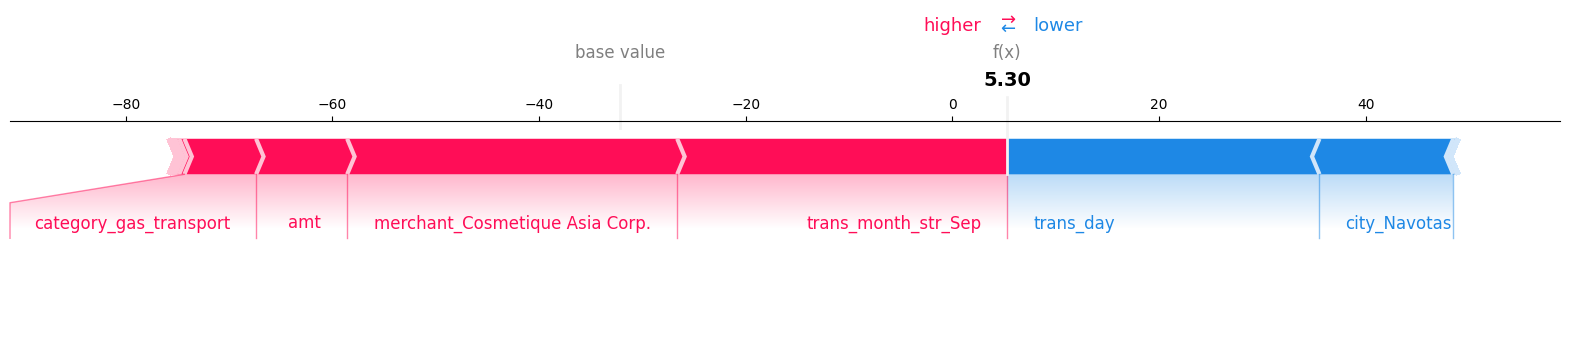

In [153]:
shap.force_plot(explainer.expected_value, 
                shap_values[1434], X_holdout.columns, matplotlib=True)

In [154]:
shap_vals = shap_values[1434]

feature_importance = pd.DataFrame(list(zip(X.columns, shap_vals)),
                                  columns=['column_value', 'shap_vals'])

feature_importance.sort_values(by=['shap_vals'], 
                               ascending=False, 
                               inplace=True)

feature_importance.head(20)

,column_value,shap_vals
226,trans_month_str_Sep,31.936100
106,merchant_Cosmetique Asia Corp.,31.935001
3,amt,8.812366
77,category_gas_transport,6.936713
32,city_San Juan,0.504649
17,city_Imus,0.374485
1,long,0.202605
31,city_San Jose del Monte,0.162544
120,merchant_Hill's Pet Nutrition Inc.,0.161110
19,city_Lucena,0.076952


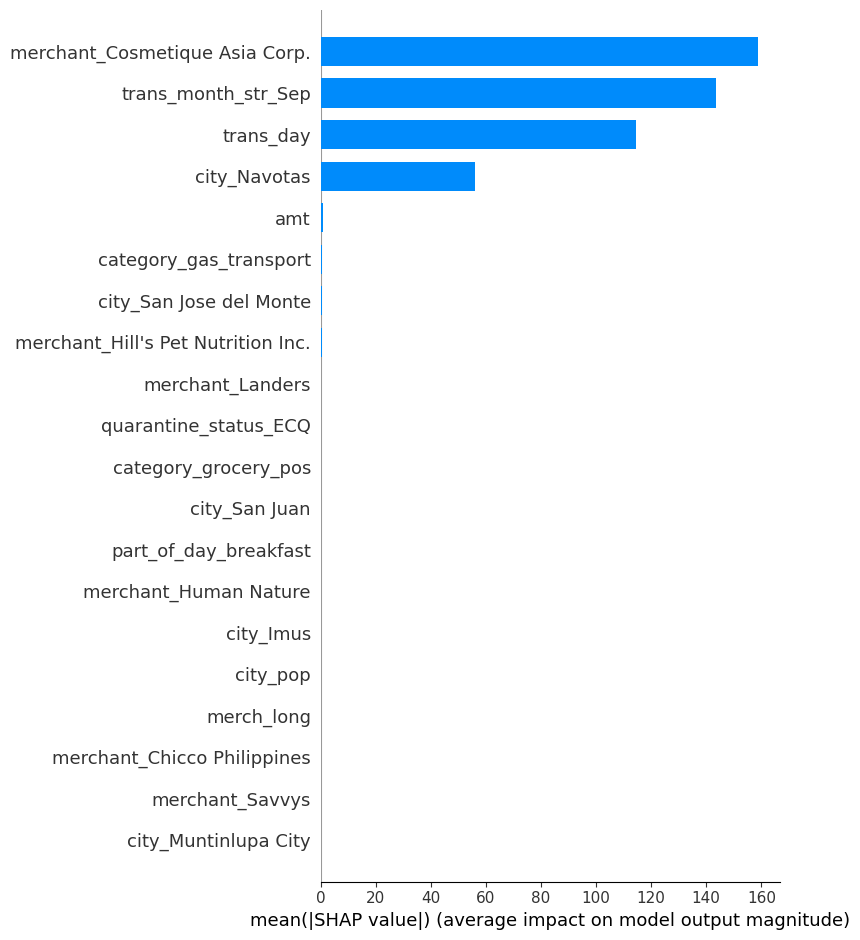

In [133]:
shap.summary_plot(shap_values=shap_values, 
                  features=X_holdout.columns, 
                  plot_type="bar")

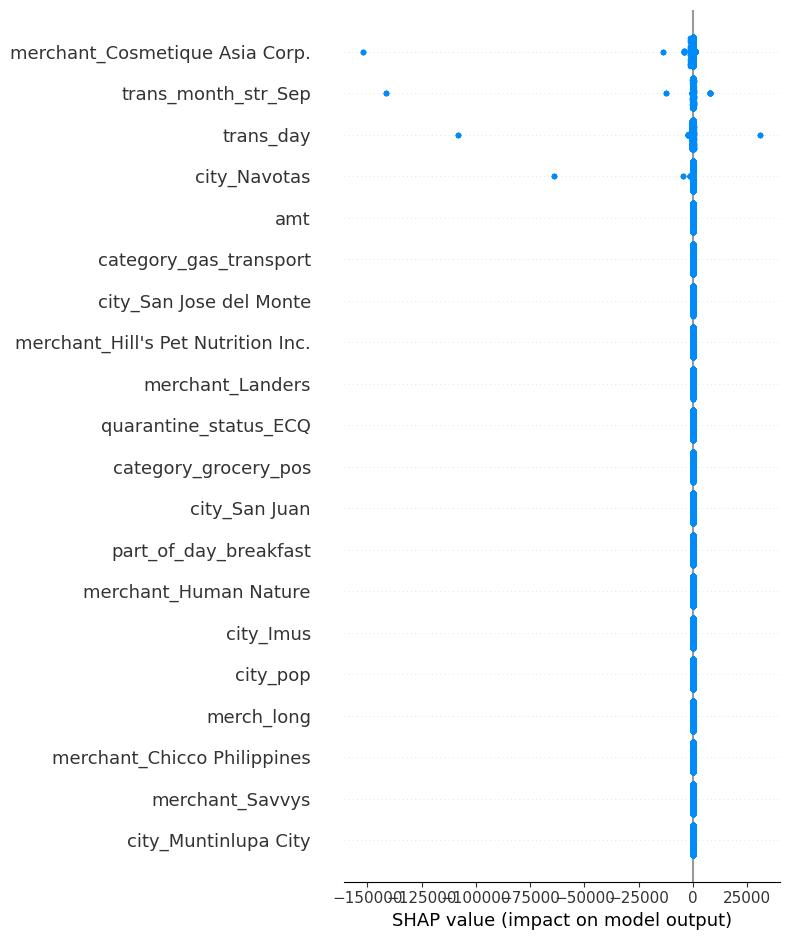

In [134]:
shap.summary_plot(shap_values = shap_values, 
                  features = X_holdout.columns)

In [162]:
explainer = LimeTabularExplainer(X_trainval.values, mode="classification",
                                 class_names=[0, 1],
                                 feature_names=X_trainval.columns,
                                 discretize_continuous=True
                                 )

In [163]:
X_holdout.iloc[1434]

lat                             13.933300
long                           121.616700
city_pop                    266248.000000
amt                              6.750000
merch_lat                       13.365401
                                ...      
quarantine_status_GCQ            1.000000
quarantine_status_MECQ           0.000000
quarantine_status_Normal         0.000000
QL_Extreme QL                    0.000000
QL_Moderate-Low QL               1.000000
Name: 28986, Length: 241, dtype: float64

In [169]:
i = 1434 
exp = explainer.explain_instance(
    X_holdout.iloc[i], 
    model.predict_proba, 
    num_features=3, 
    top_labels=1)

exp.show_in_notebook()